In [1]:
# %pip install -U scipy

In [2]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# project_dir = "/codespace/braintypicality"
# sys.path.append(project_dir)

In [3]:
import re
import json
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.colors import LogNorm

from functools import partial
from tqdm import tqdm
from scipy.stats import spearmanr, permutation_test, mannwhitneyu, PermutationMethod, false_discovery_control, rankdata
ATLAS = "AAL+CSF"
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"

TEN_PERCENT = 0.1
FIVE_PERCENT = 0.05
ONE_PERCENT = 0.01

In [4]:
def statistic(x, y, dof, axis=0):  # explore all possible pairings by permuting `x`
    rs = spearmanr(x, y, axis=axis).statistic  # ignore pvalue
    transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
    return transformed

def run_correlation_analysis(samples,
                             behavior_cols,
                             roi_score_threshold_quantile=0.8,
                             relevant_roi_columns = None,
                             correlation_thresh=0.5,
                             n_resamples=10_000):
    
    # Only keep ROIs above reference threshold on average
    if relevant_roi_columns is None:
        roi_thresh = reference_likelihoods.quantile(roi_score_threshold_quantile)
        relevant_roi_columns = samples[reference_likelihoods.columns].mean() > roi_thresh
        relevant_roi_columns = list(relevant_roi_columns[relevant_roi_columns == True].index)
    
    msma_scores = samples[relevant_roi_columns]
    behavior_scores = samples[behavior_cols]
    corrmatrix, _ = spearmanr(msma_scores, behavior_scores)
    featnames = relevant_roi_columns+behavior_cols
    corrmatrix = pd.DataFrame(corrmatrix, columns=featnames, index=featnames)
    
    dof = len(samples) - 2
    corrs = corrmatrix.loc[relevant_roi_columns, behavior_cols].stack()
#     significant_correlation = (corrs.abs() > correlation_thresh).values
#     corrs = corrs[significant_correlation]

    print("Running permutation test ... ")
    print(f"Correlation Threshold: {correlation_thresh}")
    print(f"Feature Pairs: {corrs.shape[0]} ")
    print(f"Maximum DOF: {dof} ")
    
    sigcorrs = []
    for row in tqdm(corrs.items()):
        (roi, bhv), corr = row
        x,y = samples[roi], samples[bhv]
        nonmissing = y > -1
        
        if nonmissing.sum() < 10: continue
        
        x,y = x[nonmissing], y[nonmissing]
        dof = len(x) - 2
        
        ref = permutation_test((x, ), partial(statistic, y=y, dof=dof), vectorized=False,
                               n_resamples=n_resamples, alternative='two-sided', permutation_type='pairings')
        sigcorrs.append((roi, bhv, corr, ref.pvalue, len(y)))
    
    sigcorrdf = pd.DataFrame(sigcorrs, columns=['ROI', "Behavior", "Corr", "p-value", "nsamples"]
                                ).sort_values(by='Corr', ascending=False, key=lambda x: abs(x))#.set_index(['ROI', 'Behavior'])
    
    return corrmatrix, sigcorrdf, relevant_roi_columns

## Loading Voxel-wise Scores

In [5]:
with open('data/aal-atlas-name-mapping.json', 'r') as file:
    short_to_desc = json.load(file)
short_to_desc['background'] = "Background"
short_to_desc['Frontal_Sup_Orb_L'] = 'Left Superior frontal gyrus, orbital part'
short_to_desc['Frontal_Sup_Orb_R'] = 'Right Superior frontal gyrus, orbital part'
short_to_desc['Parietal_Inf_L']    = 'Left Inferior parietal'
short_to_desc['Parietal_Inf_R']    = 'Right Inferior parietal'

In [6]:
roi_score_likelihoods = pd.read_csv(f"{workdir}/eval/heatmaps_v2/roi/{ATLAS}_roi_likelihoods.csv").rename(columns=short_to_desc)
roi_columns = roi_score_likelihoods.columns.difference(['Cohort', "ID"])
roi_score_likelihoods.describe()

Background         CSF  Left Precentral gyrus  Right Precentral gyrus  \
count  319.000000  319.000000             319.000000              319.000000   
mean   -52.319597   -0.377818             -16.516151              -16.224555   
std      3.546803    1.228652               1.456727                1.556727   
min    -56.578876   -2.319088             -18.865427              -19.293846   
25%    -54.264077   -1.154375             -17.479531              -17.163305   
50%    -53.372475   -0.594116             -16.710178              -16.546534   
75%    -51.783491   -0.008909             -15.920045              -15.728770   
max    -27.150005    7.890209              -5.713173               -5.071681   

       Left Superior frontal gyrus, dorsolateral  \
count                                 319.000000   
mean                                  -13.818043   
std                                     1.815214   
min                                   -16.664347   
25%                                   -14.953725   
50%                                   -14.171143   
75%                                   -13.174180   
max                                    -2.370178   

       Right Superior frontal gyrus, dorsolateral  \
count                                  319.000000   
mean                                   -14.786558   
std                                      1.858061   
min                                    -17.834581   
25%                                    -16.054201   
50%                                    -15.222399   
75%                                    -14.250692   
max                                     -3.197154   

       Left Superior frontal gyrus, orbital part  \
count                                 319.000000   
mean                                   -7.952232   
std                                     1.738513   
min                                   -11.162533   
25%                                    -9.079662   
50%                                    -8.296599   
75%                                    -7.268675   
max                                    -0.232863   

       Right Superior frontal gyrus, orbital part  Left Middle frontal gyrus  \
count                                  319.000000                 319.000000   
mean                                    -7.362655                 -14.798461   
std                                      1.847489                   1.813877   
min                                    -10.705958                 -17.992964   
25%                                     -8.609350                 -15.953917   
50%                                     -7.697394                 -15.106338   
75%                                     -6.743108                 -14.188337   
max                                      2.750425                  -4.293357   

       Right Middle frontal gyrus  ...  \
count                  319.000000  ...   
mean                   -14.637856  ...   
std                      1.835720  ...   
min                    -17.878504  ...   
25%                    -15.746493  ...   
50%                    -15.056453  ...   
75%                    -14.231890  ...   
max                     -1.176398  ...   

       Left Lobule X of cerebellar hemisphere  \
count                              319.000000   
mean                                -3.204714   
std                                  1.930059   
min                                 -8.171700   
25%                                 -4.510982   
50%                                 -3.428044   
75%                                 -2.331557   
max                                  4.721942   

       Right Lobule X of cerebellar hemisphere  Lobule I, II of vermis  \
count                               319.000000              319.000000   
mean                                 -2.568465                1.004282   
std                                   2.248261                3.632817   
min                             

In [7]:
reference_likelihoods = pd.read_csv(f"{workdir}/eval/heatmaps_v2/roi/training-{ATLAS}_roi_likelihoods.csv").rename(columns=short_to_desc)
reference_likelihoods

Background       CSF  Left Precentral gyrus  Right Precentral gyrus  \
0    -52.405773 -1.160594             -16.240720              -15.420356   
1    -53.402084  0.589674             -16.218039              -16.240524   
2    -53.377735  0.354789             -16.782894              -15.423598   
3    -53.366486 -1.123906             -14.828829              -16.024061   
4    -54.079800 -0.805278             -15.471673              -15.820291   
..          ...       ...                    ...                     ...   
325  -56.249020 -2.643489             -16.350897              -16.684572   
326  -52.580654 -0.585214             -14.549687              -15.862584   
327  -51.015700  0.189976             -16.854430              -16.476469   
328  -57.438920 -2.173401             -17.137371              -16.613934   
329  -53.114166 -1.181961             -16.999947              -17.979078   

     Left Superior frontal gyrus, dorsolateral  \
0                                   -13.174262   
1                                   -12.814417   
2                                   -13.801647   
3                                   -11.564390   
4                                   -12.870411   
..                                         ...   
325                                 -14.756400   
326                                 -13.132694   
327                                 -14.186939   
328                                 -14.874028   
329                                 -15.339323   

     Right Superior frontal gyrus, dorsolateral  \
0                                    -14.156552   
1                                    -14.059655   
2                                    -13.938385   
3                                    -11.740133   
4                                    -12.842586   
..                                          ...   
325                                  -15.867616   
326                                  -13.948072   
327                                  -14.068050   
328                                  -15.464175   
329                                  -15.572917   

     Left Superior frontal gyrus, orbital part  \
0                                    -7.823804   
1                                    -6.404532   
2                                    -6.296635   
3                                    -6.887378   
4                                    -9.030422   
..                                         ...   
325                                  -9.001400   
326                                  -9.040503   
327                                  -7.800881   
328                                  -9.022839   
329                                  -8.888371   

     Right Superior frontal gyrus, orbital part  Left Middle frontal gyrus  \
0                                     -4.615128                 -14.945374   
1                                     -6.504943                 -14.161819   
2                                     -6.754046                 -14.851440   
3                                     -7.011018                 -13.014995   
4                                     -6.099383                 -14.213899   
..                                          ...                        ...   
325                                   -8.668185                 -15.575353   
326                                   -7.104403                 -13.877936   
327                                   -5.969154                 -15.419061   
328                                  -10.262229                 -17.379310   
329                                   -9.644242                 -16.351866   

     Right Middle frontal gyrus  ...  Left Lobule X of cerebellar hemisphere  \
0                    -14.115917  ...                                0.274043   
1                    -14.106808  ...                                1.904382   
2                    -14.423994  ...                               -2.394596   
3                   

### Full names are adopted from various sources:

#### CBCL
- https://www.parinc.com/docs/default-source/product-resources/sample_c15.pdf
- http://crisisresponse.promoteprevent.org/webfm_send/2475

#### DAS
- https://www.myschoolpsychology.com/wp-content/uploads/2014/02/Differential-Ability-Scales.pdf

#### Vineland-II
- https://www.ualberta.ca/en/community-university-partnership/media-library/community-university-partnership/resources/tools---assessment/vinelandjune-2012.pdf

In [8]:
behavior_column_map = {
    
  "CBCL-aggr_behav_score": "CBCL-Aggressive Behavior",
  "CBCL-anx_prob_score": "CBCL-Anxiety Problems",
  "CBCL-anxious_score": "CBCL-Anxious/Depressed",
  "CBCL-attention_hyper_prob_score": "CBCL-Attention Deficit/Hyperactivity Problems",
  "CBCL-attention_prob_score": "CBCL-Attention Problems",
  "CBCL-conduct_prob_score": "CBCL-Conduct Problems",
  "CBCL-depressed_score": "CBCL-Withdrawn/Depressed",
  "CBCL-depressive_prob_score": "CBCL-Depressive Problems",
  "CBCL-externalizing_score": "CBCL-Externalizing Problems",
  "CBCL-internalizing_score": "CBCL-Internalizing Problems",
  "CBCL-obsessive_comp_prob_score": "CBCL-Obsessive-Compulsive Problems",
  "CBCL-oppo_def_prob_score": "CBCL-Oppositional Defiant Problems",
  "CBCL-rule_break_behav_score": "CBCL-Rule-Breaking Behavior",
  "CBCL-sluggish_cogn_tempo_score": "CBCL-Sluggish Cognitive Tempo",
  "CBCL-social_prob_score": "CBCL-Social Problems",
  "CBCL-som_comp_score": "CBCL-Somatic Complaints",
  "CBCL-som_prob_score": "CBCL-Somatic Problems",
  "CBCL-stress_prob_score": "CBCL-Stress Problems",
  "CBCL-thought_prob_score": "CBCL-Thought Problems",
  "CBCL-total_problems_score": "CBCL-Total Problems",
    
  "VSA DAS_SA,PC_ABILITY_SCORE": "DAS-Pattern Construction",
  "VSA DAS_SA,matrices_ABILITY_SCORE": "DAS-Matrices",
  "VSA DAS_SA,rd_ABILITY_SCORE": "DAS-Recall of Designs",
  "VSA DAS_SA,seq_qr_ABILITY_SCORE": "DAS-Sequential and Quantitative Reasoning",
  "VSA DAS_SA,verbal_similarities_ABILITY_SCORE": "DAS-Verbal Similarities",
  "VSA DAS_SA,word_defn_ABILITY_SCORE": "DAS-Word Definitions",
    
  "Vineland-community_RAW_SCORE": "Vineland-II-Community Living Skills",
  "Vineland-copy_skills_RAW_SCORE": "Vineland-II-Coping Skills",
  "Vineland-domestic_RAW_SCORE": "Vineland-II-Domestic Skills",
  "Vineland-expressive_RAW_SCORE": "Vineland-II-Expressive Communication",
  "Vineland-fine_motor_RAW_SCORE": "Vineland-II-Fine Motor Skills",
  "Vineland-gross_motor_RAW_SCORE": "Vineland-II-Gross Motor Skills",
  "Vineland-inter_pers_rel_RAW_SCORE": "Vineland-II-Interpersonal Relationships",
  "Vineland-personal_RAW_SCORE": "Vineland-II-Personal Living Skills",
  "Vineland-play_leisure_RAW_SCORE": "Vineland-II-Play and Leisure Skills",
  "Vineland-receptive_RAW_SCORE": "Vineland-II-Receptive Communication",
  "Vineland-written_RAW_SCORE": "Vineland-II-Written Communication"

}

In [9]:
ibis_metadata = pd.read_csv("/ASD/ahsan_projects/braintypicality/dataset/ibis_metadata_v2.csv")
ibis_metadata.index = ibis_metadata["CandID"].apply(lambda x: "IBIS" + str(x))
ibis_metadata.index.name = "ID"
ibis_metadata = ibis_metadata.astype(np.float32, errors="ignore")

das_cols = [c for c in ibis_metadata.columns if "DAS" in c]
cbcl_cols = list(
    filter(
        lambda c: re.match(".*CBCL.*(?<!T)_score", c),
        ibis_metadata.columns,
    )
)
vineland_cols = list(
    filter(lambda c: re.match(".*Vine.*RAW", c), ibis_metadata.columns)
)
ados_cols = list(filter(lambda c: re.match(".*ADOS.*", c), ibis_metadata.columns))

behavior_cols = cbcl_cols + das_cols + vineland_cols + ados_cols

ibis_metadata[behavior_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 423 entries, IBIS389101 to IBIS233336
Data columns (total 49 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   CBCL-aggr_behav_score                                                    423 non-null    float32
 1   CBCL-anx_prob_score                                                      423 non-null    float32
 2   CBCL-anxious_score                                                       423 non-null    float32
 3   CBCL-attention_hyper_prob_score                                          423 non-null    float32
 4   CBCL-attention_prob_score                                                423 non-null    float32
 5   CBCL-conduct_prob_score                                                  423 non-null    float32
 6   CBCL-depressed_score                                           

In [10]:
das_cols

['VSA DAS_SA,PC_ABILITY_SCORE',
 'VSA DAS_SA,matrices_ABILITY_SCORE',
 'VSA DAS_SA,rd_ABILITY_SCORE',
 'VSA DAS_SA,seq_qr_ABILITY_SCORE',
 'VSA DAS_SA,verbal_similarities_ABILITY_SCORE',
 'VSA DAS_SA,word_defn_ABILITY_SCORE']

In [11]:
cbcl_cols

['CBCL-aggr_behav_score',
 'CBCL-anx_prob_score',
 'CBCL-anxious_score',
 'CBCL-attention_hyper_prob_score',
 'CBCL-attention_prob_score',
 'CBCL-conduct_prob_score',
 'CBCL-depressed_score',
 'CBCL-depressive_prob_score',
 'CBCL-externalizing_score',
 'CBCL-internalizing_score',
 'CBCL-obsessive_comp_prob_score',
 'CBCL-oppo_def_prob_score',
 'CBCL-rule_break_behav_score',
 'CBCL-sluggish_cogn_tempo_score',
 'CBCL-social_prob_score',
 'CBCL-som_comp_score',
 'CBCL-som_prob_score',
 'CBCL-stress_prob_score',
 'CBCL-thought_prob_score',
 'CBCL-total_problems_score']

In [12]:
vineland_cols

['Vineland-community_RAW_SCORE',
 'Vineland-copy_skills_RAW_SCORE',
 'Vineland-domestic_RAW_SCORE',
 'Vineland-expressive_RAW_SCORE',
 'Vineland-fine_motor_RAW_SCORE',
 'Vineland-gross_motor_RAW_SCORE',
 'Vineland-inter_pers_rel_RAW_SCORE',
 'Vineland-personal_RAW_SCORE',
 'Vineland-play_leisure_RAW_SCORE',
 'Vineland-receptive_RAW_SCORE',
 'Vineland-written_RAW_SCORE']

In [13]:
roi_score_likelihoods.Cohort.value_counts()

IBIS-HR-Typical    106
IBIS-LR-Typical     82
IBIS-ASD            65
IBIS-Atypical       38
IBIS-DS             28
Name: Cohort, dtype: int64

In [14]:
datadf = pd.merge(roi_score_likelihoods, ibis_metadata, on="ID").drop_duplicates(subset='ID')
datadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 0 to 315
Columns: 247 entries, Background to Sex
dtypes: float32(75), float64(118), object(54)
memory usage: 513.1+ KB


In [15]:
#datadf.to_csv("roi-msma.csv")

In [16]:
datadf.query("Cohort == 'IBIS-DS'")['Sex']

0     Female
1       Male
3       Male
4       Male
5     Female
6     Female
7       Male
8     Female
9       Male
10      Male
12    Female
13    Female
14    Female
15      Male
16    Female
17    Female
19    Female
20    Female
21      Male
22    Female
23    Female
24      Male
26    Female
27      Male
28      Male
29      Male
30      Male
31      Male
Name: Sex, dtype: object

#### Not exactly Normal distributed => we should probably use a rank-order test

<Axes: ylabel='Frequency'>

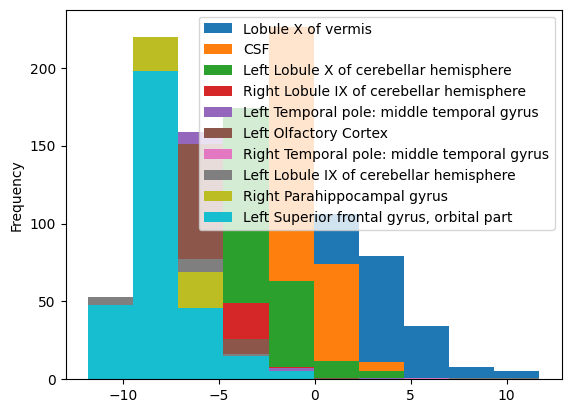

In [17]:
sorted_roi_columns = list(roi_score_likelihoods.mean(numeric_only=True).sort_values(ascending=False).index)
datadf[sorted_roi_columns[0:20:2]].plot(kind='hist')

In [18]:
# df[cbcl_cols].plot(kind='hist')

In [19]:
corrmatrix = datadf.corr(method='spearman', numeric_only=True)
corrmatrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, Background to CBCL-total_problems_score
Columns: 193 entries, Background to CBCL-total_problems_score
dtypes: float64(193)
memory usage: 296.6+ KB


CPU times: user 196 ms, sys: 129 ms, total: 325 ms
Wall time: 181 ms


<Axes: >

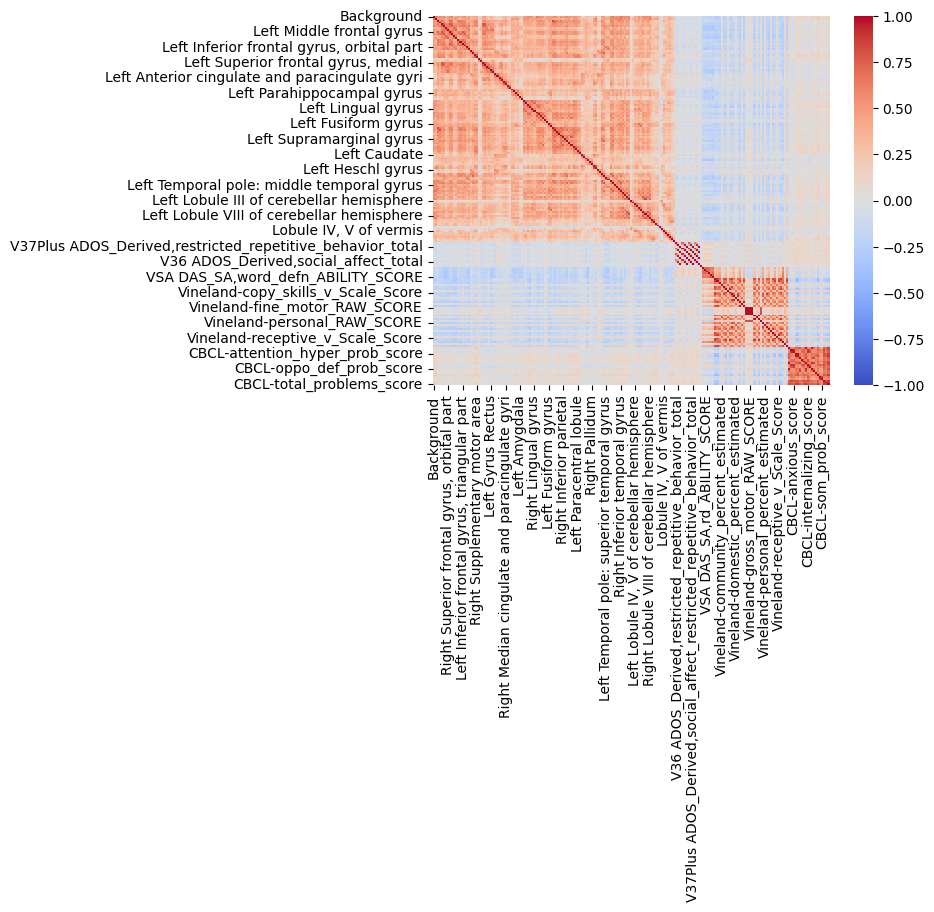

In [20]:
%%time
sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1)

In [21]:
msma_scores = datadf[sorted_roi_columns]
behavior_scores = datadf[behavior_cols]
corrmatrix, pvalues = spearmanr(msma_scores, behavior_scores)
featnames = list(msma_scores.columns) + list(behavior_scores.columns)
corrmatrix = pd.DataFrame(corrmatrix, columns=featnames, index=featnames)
pvalues = pd.DataFrame(pvalues, columns=featnames, index=featnames)

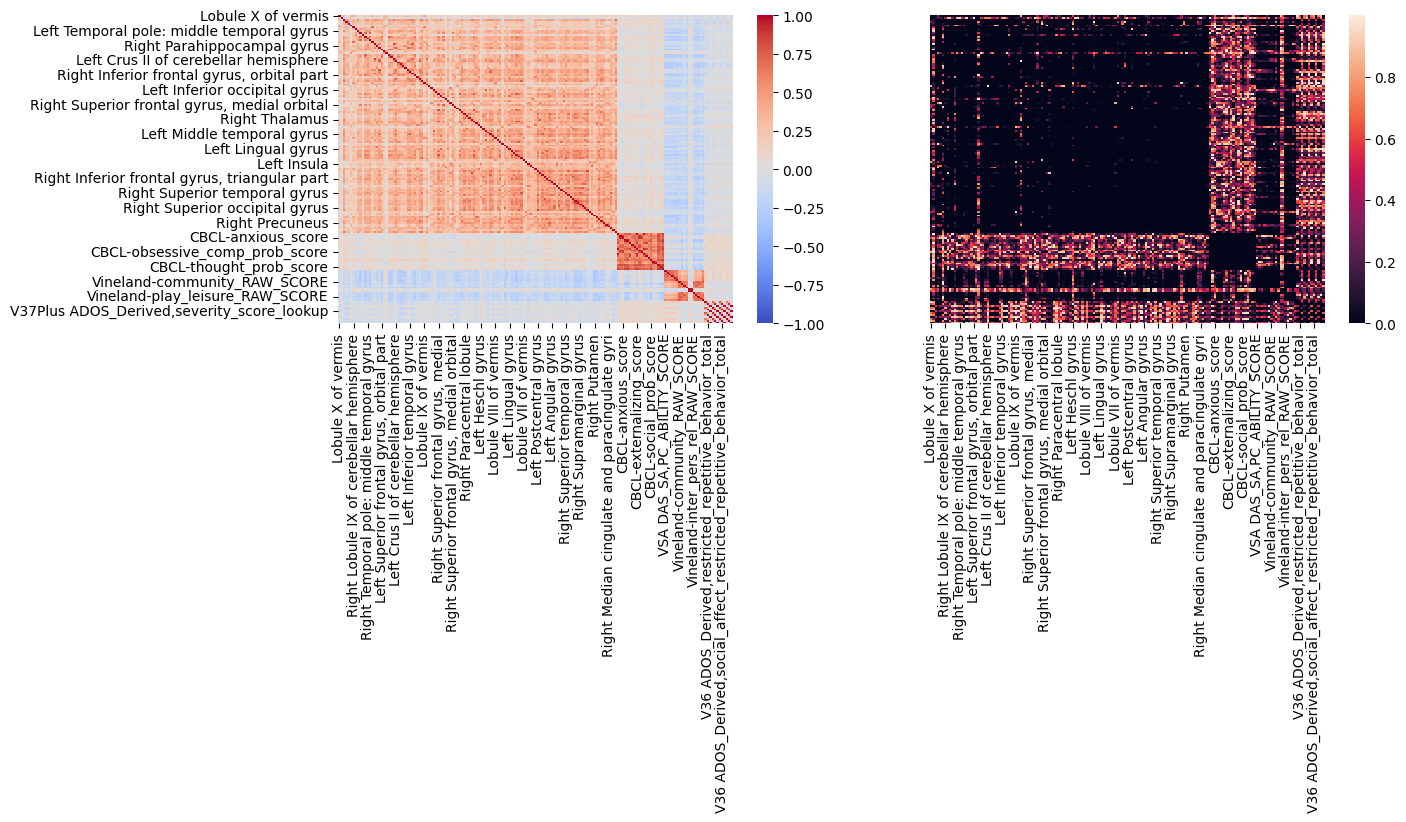

In [22]:
fig, axs = plt.subplots(1,2, figsize=(14,4))
sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0])
sns.heatmap(pvalues, ax=axs[1])
axs[1].yaxis.set_visible(False)

<Axes: >

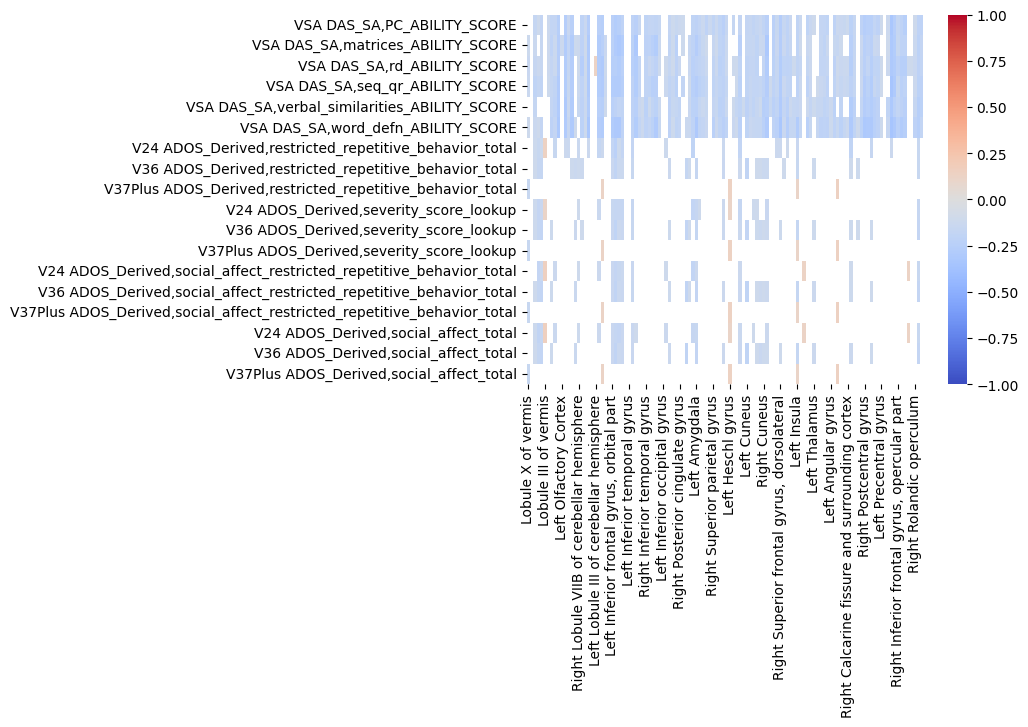

In [23]:
significant = pvalues < 0.05
sns.heatmap(corrmatrix[significant].loc[das_cols+ados_cols, sorted_roi_columns, ],  cmap='coolwarm', vmin=-1, vmax=1, )

## Separating into Atypical Cohorts

In [24]:
roi_score_likelihoods.Cohort.value_counts()

IBIS-HR-Typical    106
IBIS-LR-Typical     82
IBIS-ASD            65
IBIS-Atypical       38
IBIS-DS             28
Name: Cohort, dtype: int64

<Axes: ylabel='Frequency'>

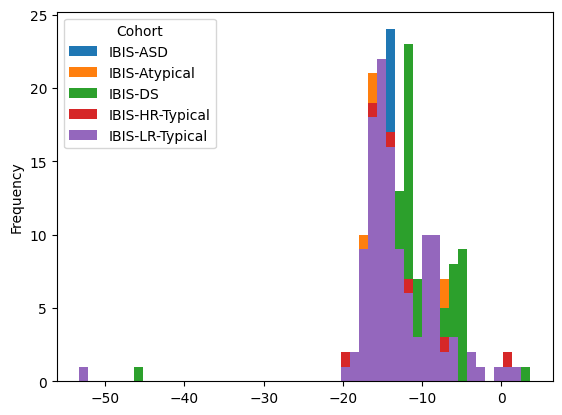

In [25]:
roi_score_likelihoods.drop(columns='ID').pivot_table(columns='Cohort').plot.hist(bins=50)

In [26]:
plotdf = roi_score_likelihoods.query("Cohort == 'IBIS-DS' | Cohort == 'IBIS-LR-Typical'")[list(roi_columns) + ['Cohort']].pivot_table(columns='Cohort')
plotdf = plotdf.melt()
plotdf.head()

Cohort      value
0  IBIS-DS -45.307087
1  IBIS-DS   2.046153
2  IBIS-DS -11.306047
3  IBIS-DS -13.674785
4  IBIS-DS -15.093185

<Axes: xlabel='value', ylabel='Density'>

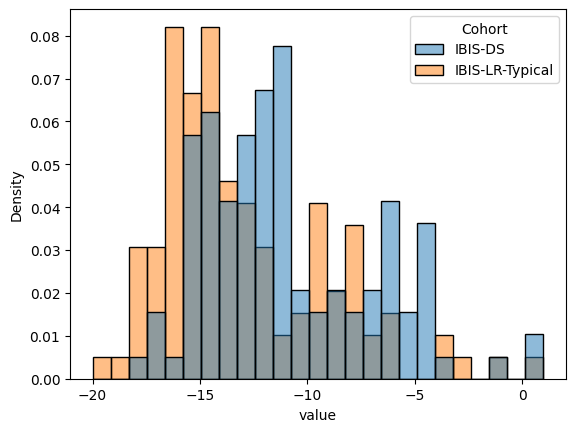

In [27]:
sns.histplot(plotdf, x='value', hue='Cohort', kde=False, stat='density', binrange=(-20,1), bins=25)

In [28]:
atypicals = datadf[datadf['Cohort'].isin(['IBIS-DS'])]
msma_scores = atypicals[sorted_roi_columns]
behavior_scores = atypicals[behavior_cols]

corrmatrix, pvalues = spearmanr(msma_scores, behavior_scores)
featnames = sorted_roi_columns+behavior_cols
corrmatrix = pd.DataFrame(corrmatrix, columns=featnames, index=featnames)
pvalues = pd.DataFrame(pvalues, columns=featnames, index=featnames)

/home/amahmood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amahmood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [29]:
# behavior_scores[cbcl_cols].plot(kind='hist', subplots=True, layout=(5,4), figsize=(12,12))

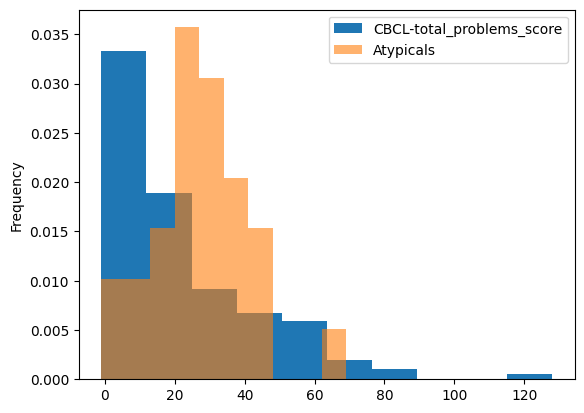

In [30]:
datadf['CBCL-total_problems_score'].plot(kind='hist', density=True)
behavior_scores['CBCL-total_problems_score'].plot(kind='hist', density=True,label="Atypicals", alpha=0.6)
plt.legend()

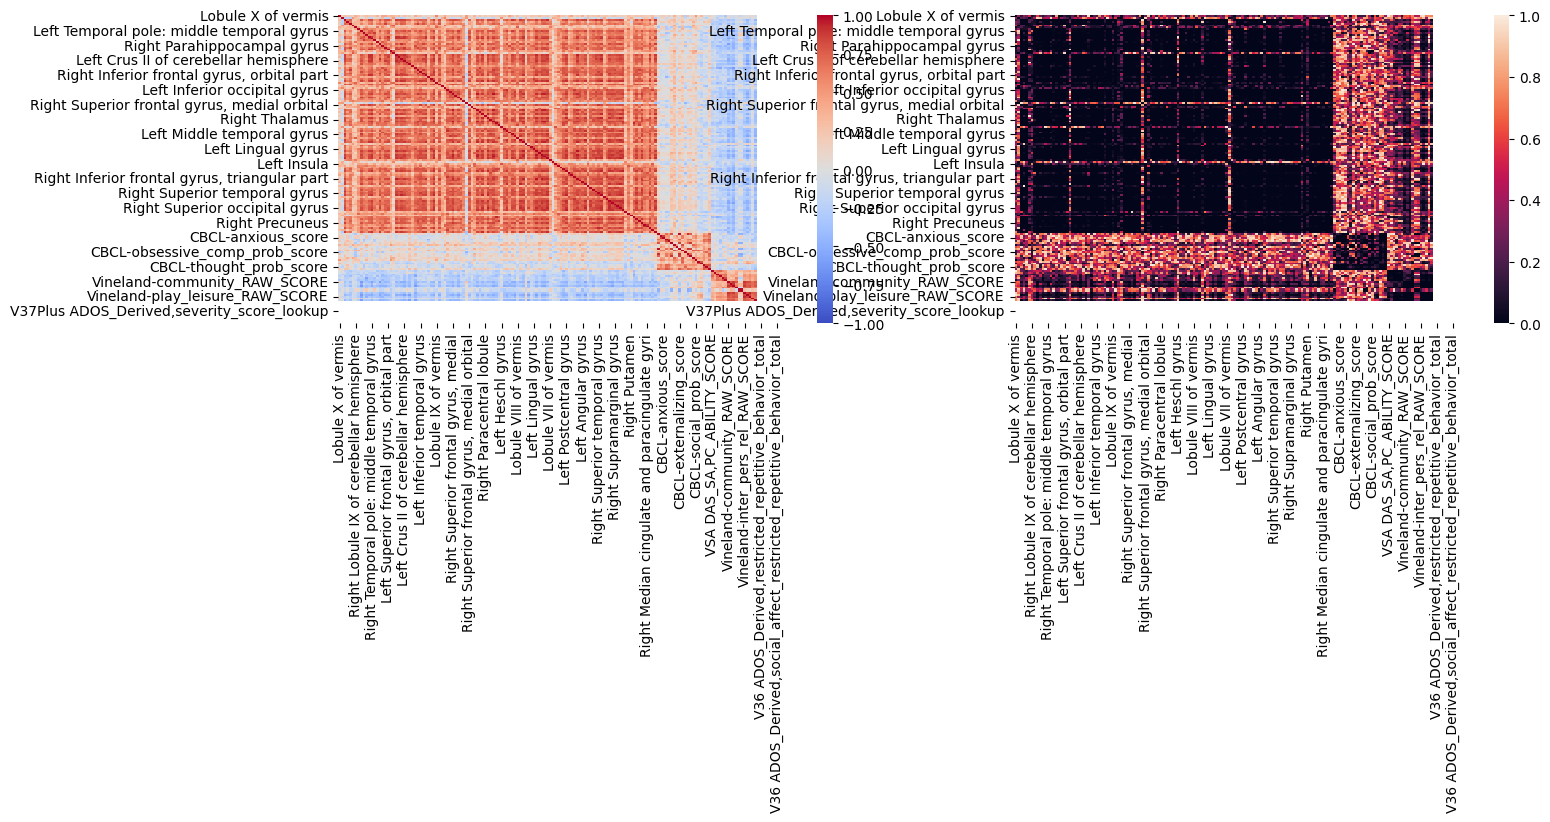

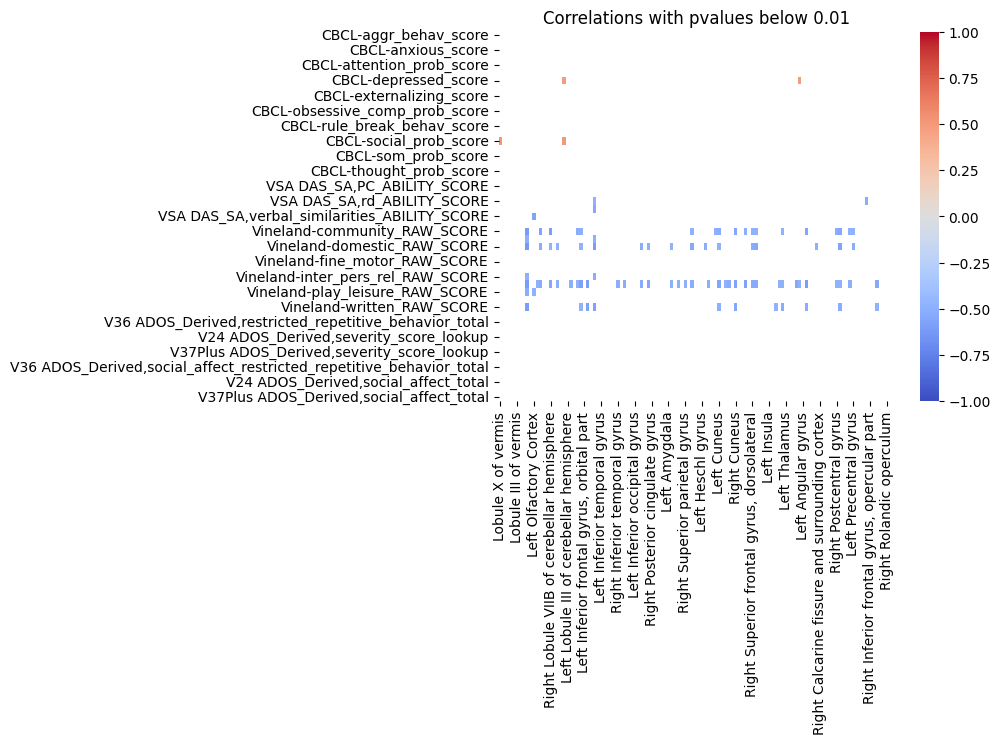

In [31]:
fig, axs = plt.subplots(1,2, figsize=(16,4))
sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0])
sns.heatmap(pvalues, ax=axs[1])
plt.show()

pval = 0.01
significant = pvalues < pval
sns.heatmap(corrmatrix[significant].loc[behavior_cols, sorted_roi_columns],  cmap='coolwarm',
            vmin=-1, vmax=1, )
plt.title(f"Correlations with pvalues below {pval}");

### Correlations between different behavior scores

In [32]:
cval = 0.4
significant_correlation = corrmatrix.abs() > cval

Text(0.5, 1.0, 'Absolute correlations above 0.4')

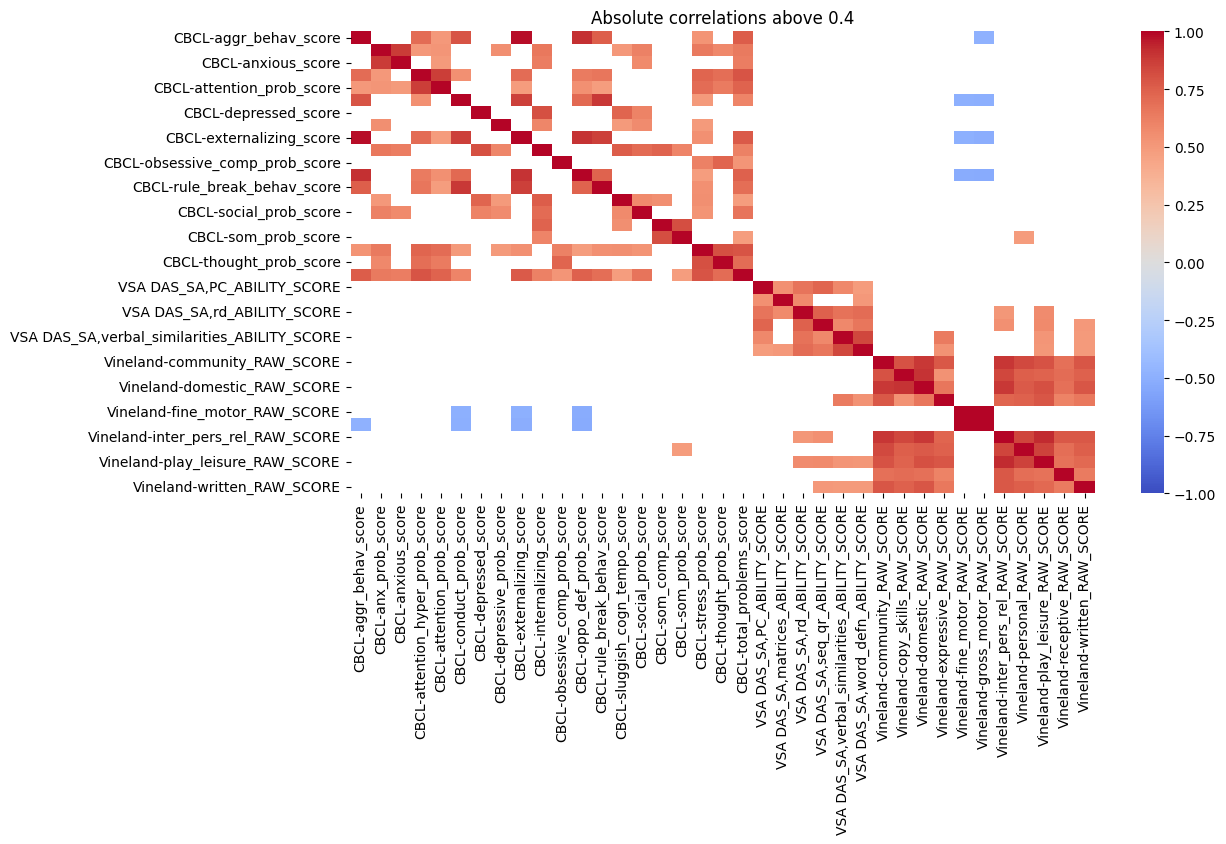

In [33]:
corrs = corrmatrix[significant].loc[behavior_cols, behavior_cols]
keepcols = corrs.count()[corrs.count() > 2].index
plt.figure(figsize=(12,6))
sns.heatmap(corrs.loc[keepcols, keepcols],cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"Absolute correlations above {cval}")

Text(0.5, 1.0, 'Absolute correlations above 0.4')

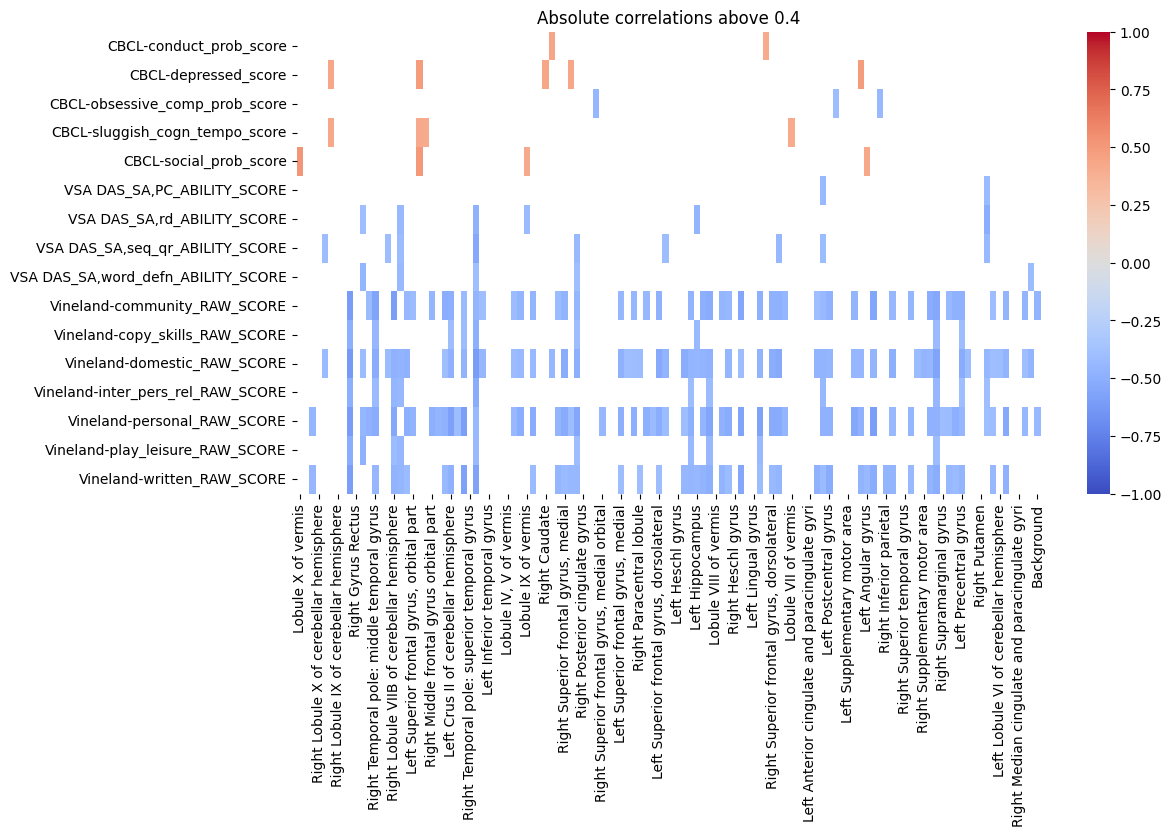

In [34]:
corrs = corrmatrix[significant_correlation].loc[sorted_roi_columns, behavior_cols]
keepcols = corrs.count()[corrs.count() > 1].index
plt.figure(figsize=(12,6))
sns.heatmap(corrmatrix[significant_correlation].loc[keepcols, sorted_roi_columns],
            cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"Absolute correlations above {cval}")

### Which Assessment shows high correlation with MSMA scores?

In [35]:
corrmatrix[significant_correlation].loc[sorted_roi_columns, behavior_cols].count(axis='rows').sort_values(ascending=False)[:10]

Vineland-personal_RAW_SCORE           58
Vineland-domestic_RAW_SCORE           54
Vineland-community_RAW_SCORE          48
Vineland-written_RAW_SCORE            45
Vineland-inter_pers_rel_RAW_SCORE     11
Vineland-play_leisure_RAW_SCORE       10
Vineland-copy_skills_RAW_SCORE         9
VSA DAS_SA,seq_qr_ABILITY_SCORE        9
VSA DAS_SA,rd_ABILITY_SCORE            6
VSA DAS_SA,word_defn_ABILITY_SCORE     5
dtype: int64

### Which Brain ROIs shows high correlation with assessments?

<Axes: >

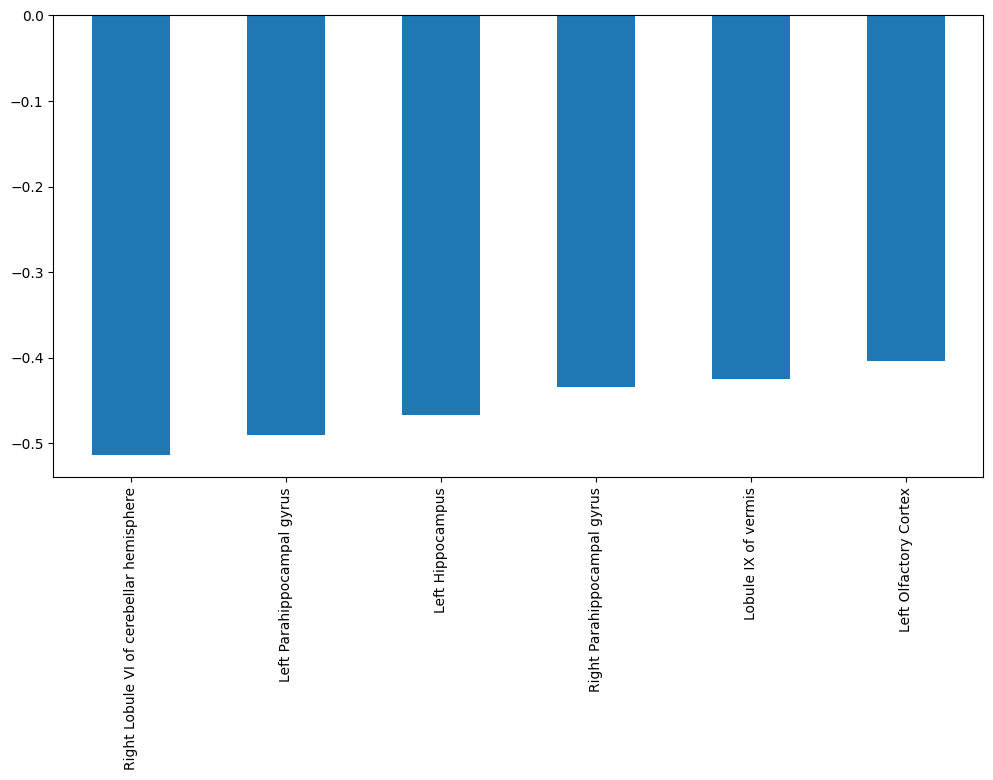

In [36]:
corrmatrix[significant_correlation].loc[sorted_roi_columns, 'VSA DAS_SA,rd_ABILITY_SCORE'].dropna().sort_values().plot(kind='bar', figsize=(12,6))

In [37]:
spearmanr(msma_scores['CSF'], behavior_scores['VSA DAS_SA,rd_ABILITY_SCORE'])

SignificanceResult(statistic=-0.174731744855214, pvalue=0.3738373102138678)

In [38]:
%%time
x,y = msma_scores['CSF'], behavior_scores['VSA DAS_SA,seq_qr_ABILITY_SCORE']
ref = permutation_test((x, ), partial(statistic, y=y, dof=len(msma_scores)), vectorized=False,
                       alternative='two-sided', permutation_type='pairings')

ref

CPU times: user 9.26 s, sys: 1.63 ms, total: 9.27 s
Wall time: 9.29 s


PermutationTestResult(statistic=-1.9407298601723086, pvalue=0.0748, null_distribution=array([-0.42917726, -1.56844226,  0.42475449, ...,  1.2085381 ,
        1.30683716, -0.35263432]))

In [39]:
plotdf = datadf.copy()
plotdf[sorted_roi_columns+behavior_cols] = plotdf[sorted_roi_columns+behavior_cols].apply(rankdata)

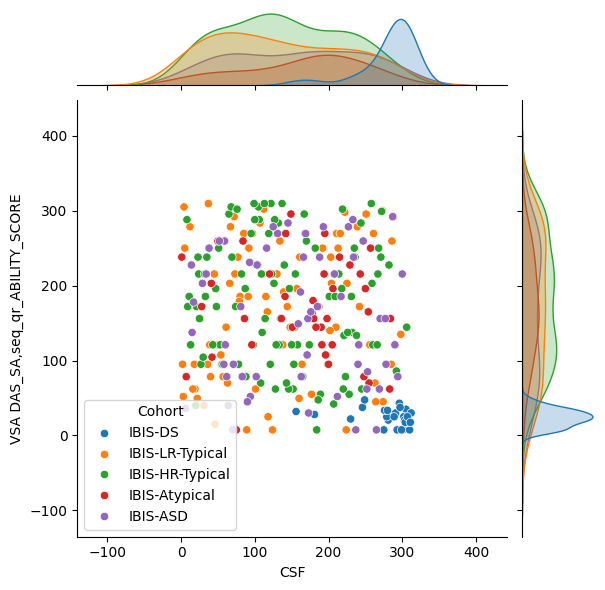

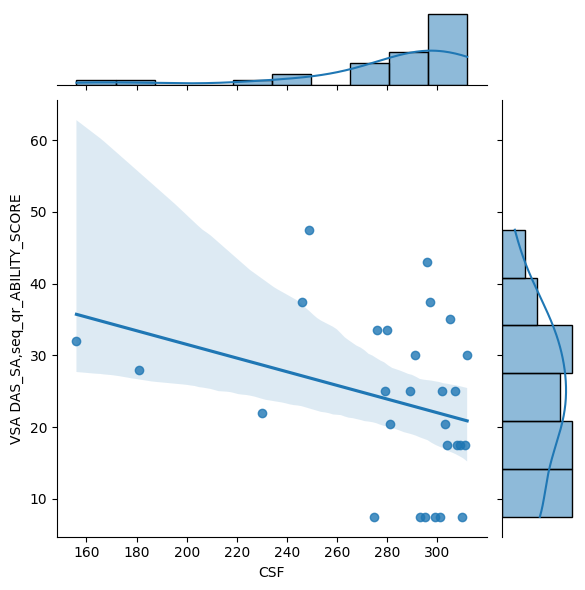

In [40]:
sns.jointplot(x='CSF', y='VSA DAS_SA,seq_qr_ABILITY_SCORE', data=plotdf, hue='Cohort',)
plt.show()
sns.jointplot(x='CSF', y='VSA DAS_SA,seq_qr_ABILITY_SCORE', data=plotdf.query("Cohort == 'IBIS-DS'"), kind='reg',)

In [41]:
plotdf.query("Cohort == 'IBIS-DS'").Sex.value_counts()

Female    14
Male      14
Name: Sex, dtype: int64

# Analyzing DS-Prototype Samples 

#### Grabbing DS ROI likelihoods and merging with metadata

In [42]:
dssamples = datadf.query("Cohort == 'IBIS-DS'")
ds_metadata = pd.read_csv("/ASD/ahsan_projects/braintypicality/dataset/ds_metadata.csv").replace(np.nan, 0)
ds_metadata['ASD-Cutoff'] = ds_metadata['MetASDCutOff'].map({0: False, 1: True})
ds_metadata['ID'] = "IBIS" + ds_metadata['CandID'].astype(str)
dssamples = pd.merge(dssamples, ds_metadata, on='ID')
dssamples.head(2)

Background       CSF  Left Precentral gyrus  Right Precentral gyrus  \
0  -38.342600  3.548188             -11.646181               -9.907785   
1  -42.486153  1.753893             -15.714825              -14.254395   

   Left Superior frontal gyrus, dorsolateral  \
0                                  -7.934814   
1                                 -11.120783   

   Right Superior frontal gyrus, dorsolateral  \
0                                   -9.100883   
1                                  -10.769796   

   Left Superior frontal gyrus, orbital part  \
0                                  -2.757597   
1                                  -3.553080   

   Right Superior frontal gyrus, orbital part  Left Middle frontal gyrus  \
0                                   -2.158922                  -9.024731   
1                                   -1.557293                 -11.703229   

   Right Middle frontal gyrus  ...  SATotalMod3  MetASDCutOff  CandID_y  \
0                   -8.604287  ...       #NULL!           0.0    105477   
1                   -9.776938  ...       #NULL!           1.0    110925   

   VSA demographics,ASD_Ever_DSMIV  VSA demographics,ASD_Ever_DSMV  \
0                             ASD-                            ASD-   
1                       ASD+ (VSA)                            ASD-   

   VSA demographics,Age_at_visit_start  VSA demographics,Risk  \
0                                136.0                    0.0   
1                                116.0                    0.0   

   VSA demographics,Sex  VSA demographics,candidate_race  ASD-Cutoff  
0                Female                            white       False  
1                  Male                            white        True  

[2 rows x 280 columns]

In [43]:
ds_metadata.columns

Index(['Identifiers', 'Group1LR2HR3HR4DS', 'CVD_Visit', 'RRBCSS_Mod1',
       'RRBCSS_Mod2', 'RRBCSS_Mod3', 'RRBCSS_Combo', 'SACSS_Mod2',
       'SACSS_Mod2_A', 'SACSS_Mod3', 'SACSS_Combo', 'CSS_Mod1', 'CSS_Mod2',
       'CSS_Mod3', 'CSS_Combo', 'RRBTotalMod1', 'SARRBTotalMod1',
       'SATotalMod1', 'RRBTotalMod2', 'SARRBTotalMod2', 'SATotalMod2',
       'RRBTotalMod3', 'SARRBTotalMod3', 'SATotalMod3', 'MetASDCutOff',
       'CandID', 'VSA demographics,ASD_Ever_DSMIV',
       'VSA demographics,ASD_Ever_DSMV', 'VSA demographics,Age_at_visit_start',
       'VSA demographics,Risk', 'VSA demographics,Sex',
       'VSA demographics,candidate_race', 'ASD-Cutoff', 'ID'],
      dtype='object')

### Protoypes are retrieved from prerun SOM labels (via `down_syndrome_som.ipynb`)

In [44]:
ds_bmu_ids = pd.read_csv("data/ds_prototypes_11x11.csv")
largest_prototype_bmu_idx = ds_bmu_ids.groupby('bmu').count().idxmax()[0]
ds_max_prototype_ids = ds_bmu_ids[ds_bmu_ids.bmu == largest_prototype_bmu_idx]['ID']
prot_ids_set = set(ds_max_prototype_ids)

ds_prototypes = dssamples.merge(ds_max_prototype_ids, on='ID')
ds_non_prototypes = dssamples[~dssamples['ID'].isin(ds_max_prototype_ids)]
len(ds_prototypes), len(ds_non_prototypes)

(16, 12)

In [45]:
dssamples.loc[:, 'Subpopulation'] = dssamples['ID'].isin(prot_ids_set)
dssamples.loc[:, 'Subpopulation'] = dssamples['Subpopulation'].map({True:"Maximal-Prototype", False: "Non-Prototype"})
dssamples['Subpopulation'].value_counts()

Maximal-Prototype    16
Non-Prototype        12
Name: Subpopulation, dtype: int64

### Relevant ROIS = ROI average across DS > 90%-tile of Typical AND Signficantly different between Proto & Non-Proto

In [46]:
relevant_rois = datadf.query("Cohort == 'IBIS-DS'")[roi_columns].mean() > datadf.query("Cohort == 'IBIS-LR-Typical'")[roi_columns].quantile(0.9)
relevant_rois = relevant_rois.index[relevant_rois]
relevant_rois = relevant_rois.drop(['Background'])
len(relevant_rois)

71

In [47]:
%%time
np.random.seed(42)
statistics = []

for c in tqdm(relevant_rois):
    statistics.append(
        mannwhitneyu(ds_prototypes[c], ds_non_prototypes[c],
                     method=PermutationMethod(n_resamples=20_000))
    )

100%|██████████| 71/71 [00:05<00:00, 13.46it/s]

CPU times: user 4.8 s, sys: 475 ms, total: 5.28 s
Wall time: 5.28 s


In [48]:
pvals = np.asarray([s.pvalue for s in statistics])
adjusted_ps = false_discovery_control(pvals, method='bh')
alpha = 0.01
print(f"FDR: {alpha} -> Significant ROIs: {(adjusted_ps < alpha).sum()} / {len(relevant_rois)}")
alpha = FIVE_PERCENT
print(f"FDR: {alpha} -> Significant ROIs: {(adjusted_ps < alpha).sum()} / {len(relevant_rois)}")

FDR: 0.01 -> Significant ROIs: 55 / 71
FDR: 0.05 -> Significant ROIs: 60 / 71


#### Using Bonferoni Correction

In [49]:
ntests = len(pvals)
alphacBonf = alpha / float(ntests)
pvals_corrected = pvals * float(ntests)

significant_prototype_rois = [roi for roi, pval in zip(relevant_rois, pvals) if pval < alphacBonf]
len(significant_prototype_rois)

40

In [50]:
prototype_rois = pd.DataFrame(np.stack([relevant_rois, pvals, pvals_corrected], axis=1),
                                          columns=['ROI', 'p-value', 'adjusted']).sort_values(by='adjusted')
significant_prototype_rois = prototype_rois[prototype_rois['p-value'] < alphacBonf]
roi_order = significant_prototype_rois.sort_values(by='p-value', ascending=True)['ROI'].values

plotdf = dssamples.melt(id_vars=['Sex', 'Subpopulation', 'ASD-Cutoff'], var_name='ROI', value_name='Anomaly Score')
plotdf = plotdf[plotdf['ROI'].isin(significant_prototype_rois['ROI'])]
plotdf = plotdf.sort_values(by='Anomaly Score')
plotdf

Sex      Subpopulation  ASD-Cutoff  \
1902    Male      Non-Prototype       False   
1938    Male      Non-Prototype       False   
1945    Male      Non-Prototype       False   
1940    Male      Non-Prototype       False   
1762    Male      Non-Prototype       False   
...      ...                ...         ...   
2674  Female  Maximal-Prototype        True   
1442  Female  Maximal-Prototype        True   
3056  Female  Maximal-Prototype       False   
1414  Female  Maximal-Prototype        True   
42    Female  Maximal-Prototype        True   

                                          ROI Anomaly Score  
1902                      Right Angular gyrus     -19.04463  
1938                          Right Precuneus    -18.815506  
1945                          Right Precuneus    -18.665321  
1940                          Right Precuneus     -18.37006  
1762                   Left Inferior parietal     -18.33248  
...                                       ...           ...  
2674   Right Crus II of cerebellar hemisphere      5.221198  
1442           Right Superior occipital gyrus      5.739893  
3056  Right Lobule X of cerebellar hemisphere      7.006848  
1414            Left Superior occipital gyrus      7.664681  
42                                        CSF      7.890209  

[1120 rows x 5 columns]

<Axes: xlabel='ASD-Cutoff', ylabel='Anomaly Score'>

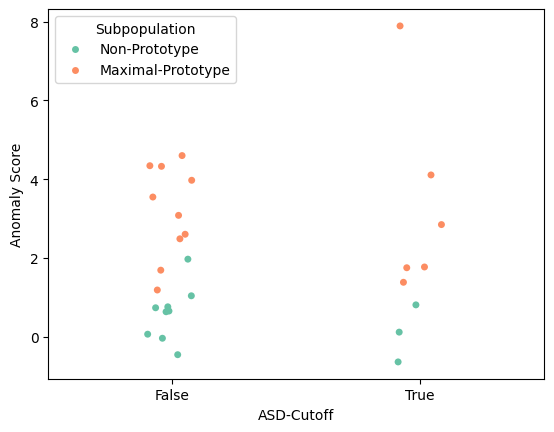

In [51]:
sns.stripplot(data=plotdf.query("ROI == 'CSF'"), y='Anomaly Score', x='ASD-Cutoff',
             hue='Subpopulation', legend=True, palette="Set2")

<Axes: xlabel='Anomaly Score', ylabel='Count'>

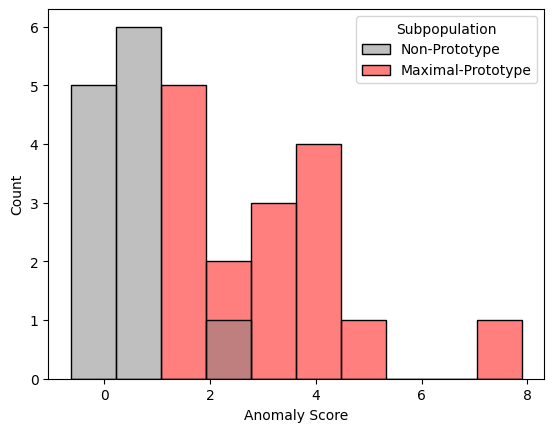

In [52]:
sns.histplot(data=plotdf.query("ROI == 'CSF'"), x='Anomaly Score',
             hue='Subpopulation', bins=10, legend=True, palette=['gray', 'red'])

In [53]:
# Set the axis title font size using rcParams
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['figure.titlesize'] = 20
# plt.rcParams['axes.titlesize'] = 16
sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 20, "axes.titlesize":22})

/tmp/ipykernel_9183/3477444513.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
/tmp/ipykernel_9183/3477444513.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
/tmp/ipykernel_9183/3477444513.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
/tmp/ipykernel_9183/3477444513.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35)


Text(0.5, 1.02, 'Higher is Anomalous ($\\uparrow$)')

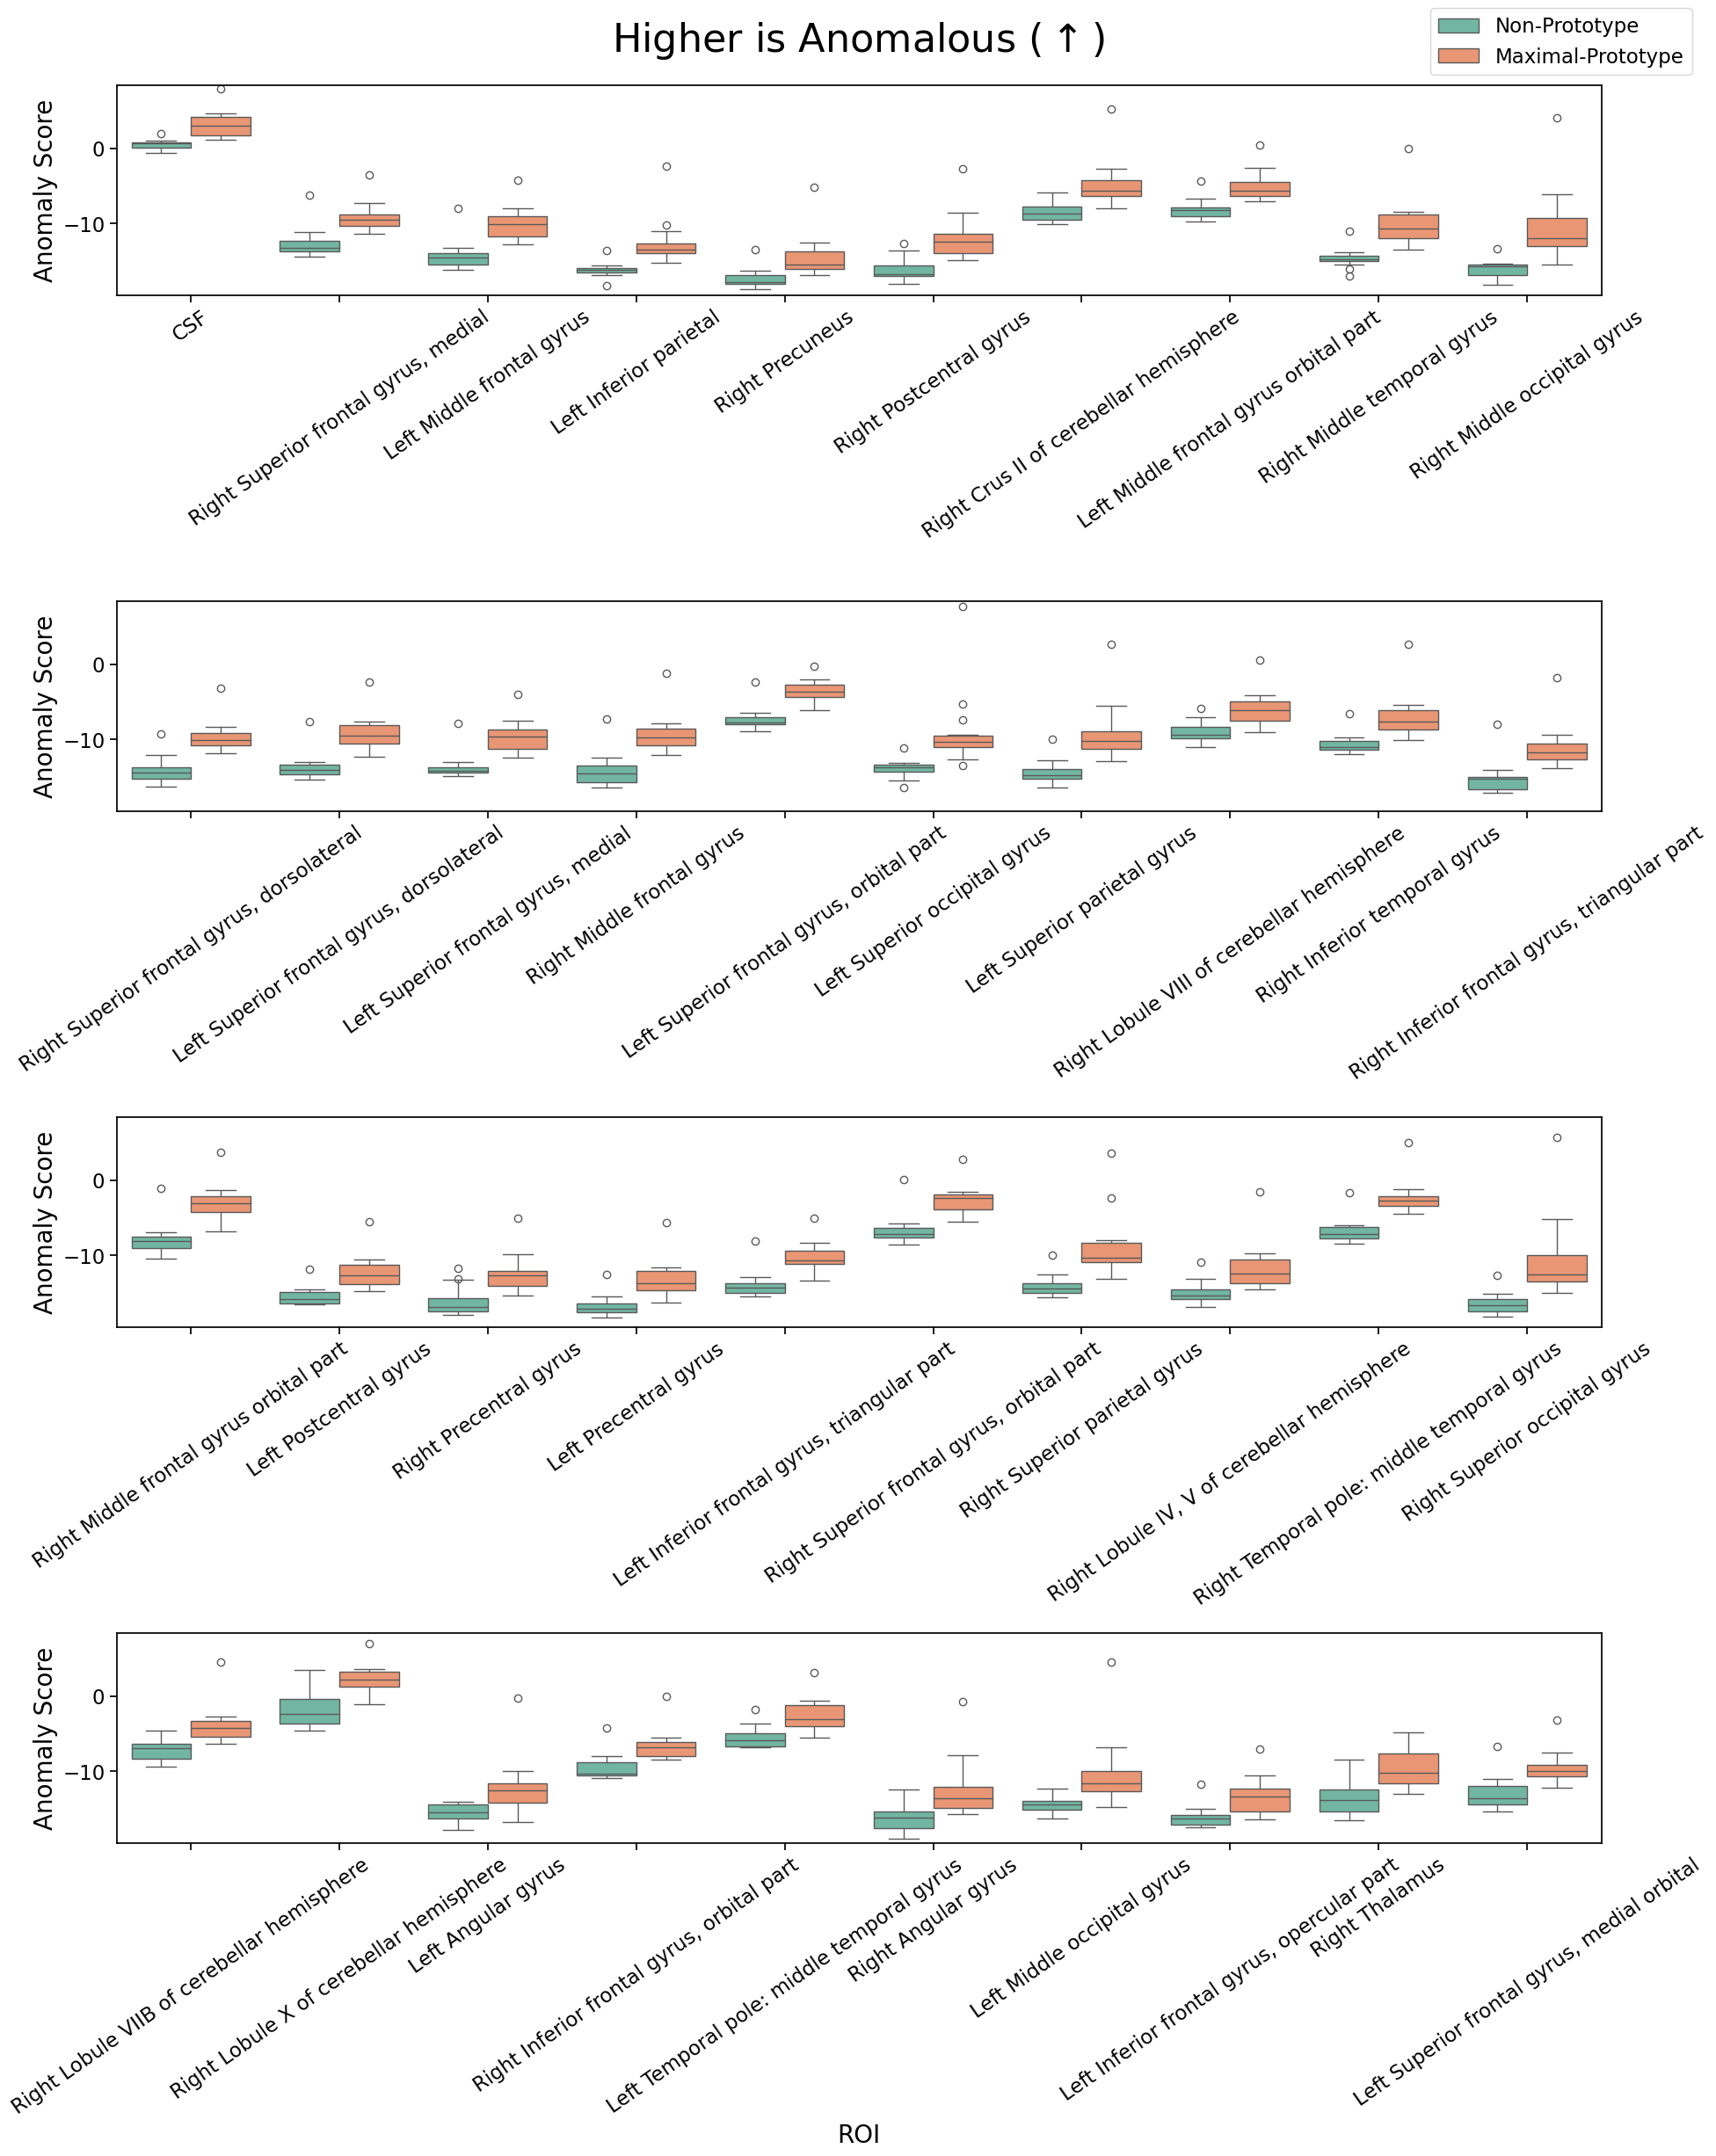

In [54]:
fig, axs = plt.subplots(4,1, figsize=(20, 24))
vmin, vmax = plotdf['Anomaly Score'].min()-0.5, plotdf['Anomaly Score'].max()+0.5
n_per_row = 10
rois_per_row = [roi_order[i:i+n_per_row] for i in range(0, len(roi_order), n_per_row) ]

for i, (ax, _rois) in enumerate(zip(axs, rois_per_row)):
    sns.boxplot(plotdf, x="ROI", y='Anomaly Score', hue='Subpopulation', order=_rois,
                orient='v', palette='Set2', ax=ax, legend=i==0)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
    ax.set_ylim(vmin, vmax)
    if i+1 < len(axs):
        ax.set_xlabel('')
        
    if i==0:
#         ax.legend_.remove()
        
#     if show_legend:
#         show_legend = False
        fig.legend(loc='upper right', bbox_to_anchor=(0.98, 1.03)) #fontsize='large')
        l = ax.legend()
        l.set_visible(False)

# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels,  loc='upper right', bbox_to_anchor=(0.98, 1.03),)
# plt.suptitle("ROIs that are Signficantly Different")
plt.tight_layout()
fig.suptitle(r"Higher is Anomalous ($\uparrow$)", y=1.02, fontsize=32)
# plt.tight_layout(w_pad=2, h_pad=2)
# plt.subplots_adjust(top=0.11)

# plt.savefig('figures/roi_full_boxplot.pdf', dpi=150, bbox_inches='tight')

In [55]:
def add_refline(data, q=0.9, **kws):
    roi = data.iloc[0]['ROI']
    protomedian = plotdf.query(f"Subpopulation == 'Maximal-Prototype' & ROI == '{roi}'")['Anomaly Score'].median()
    p = significant_prototype_rois.query(f"ROI == '{roi}'")['adjusted'].item()
    ax = plt.gca()
#     refline = reference_likelihoods[roi].quantile(0.99)
    refline = roi_score_likelihoods.query("Cohort == 'IBIS-LR-Typical' ")[roi].quantile(q)
    ax.axvline(refline, c='red', linestyle='dashed', label=f'Inlier {int(q*100):d} %-tile')
    ax.axvline(protomedian, c='black', linestyle='--', label='Prototype 50 %-tile')
    ax.set_title(roi + f' | p = {p:.3f}', fontsize=14)

/home/amahmood/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/amahmood/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/amahmood/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_9183/59326650.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=2)


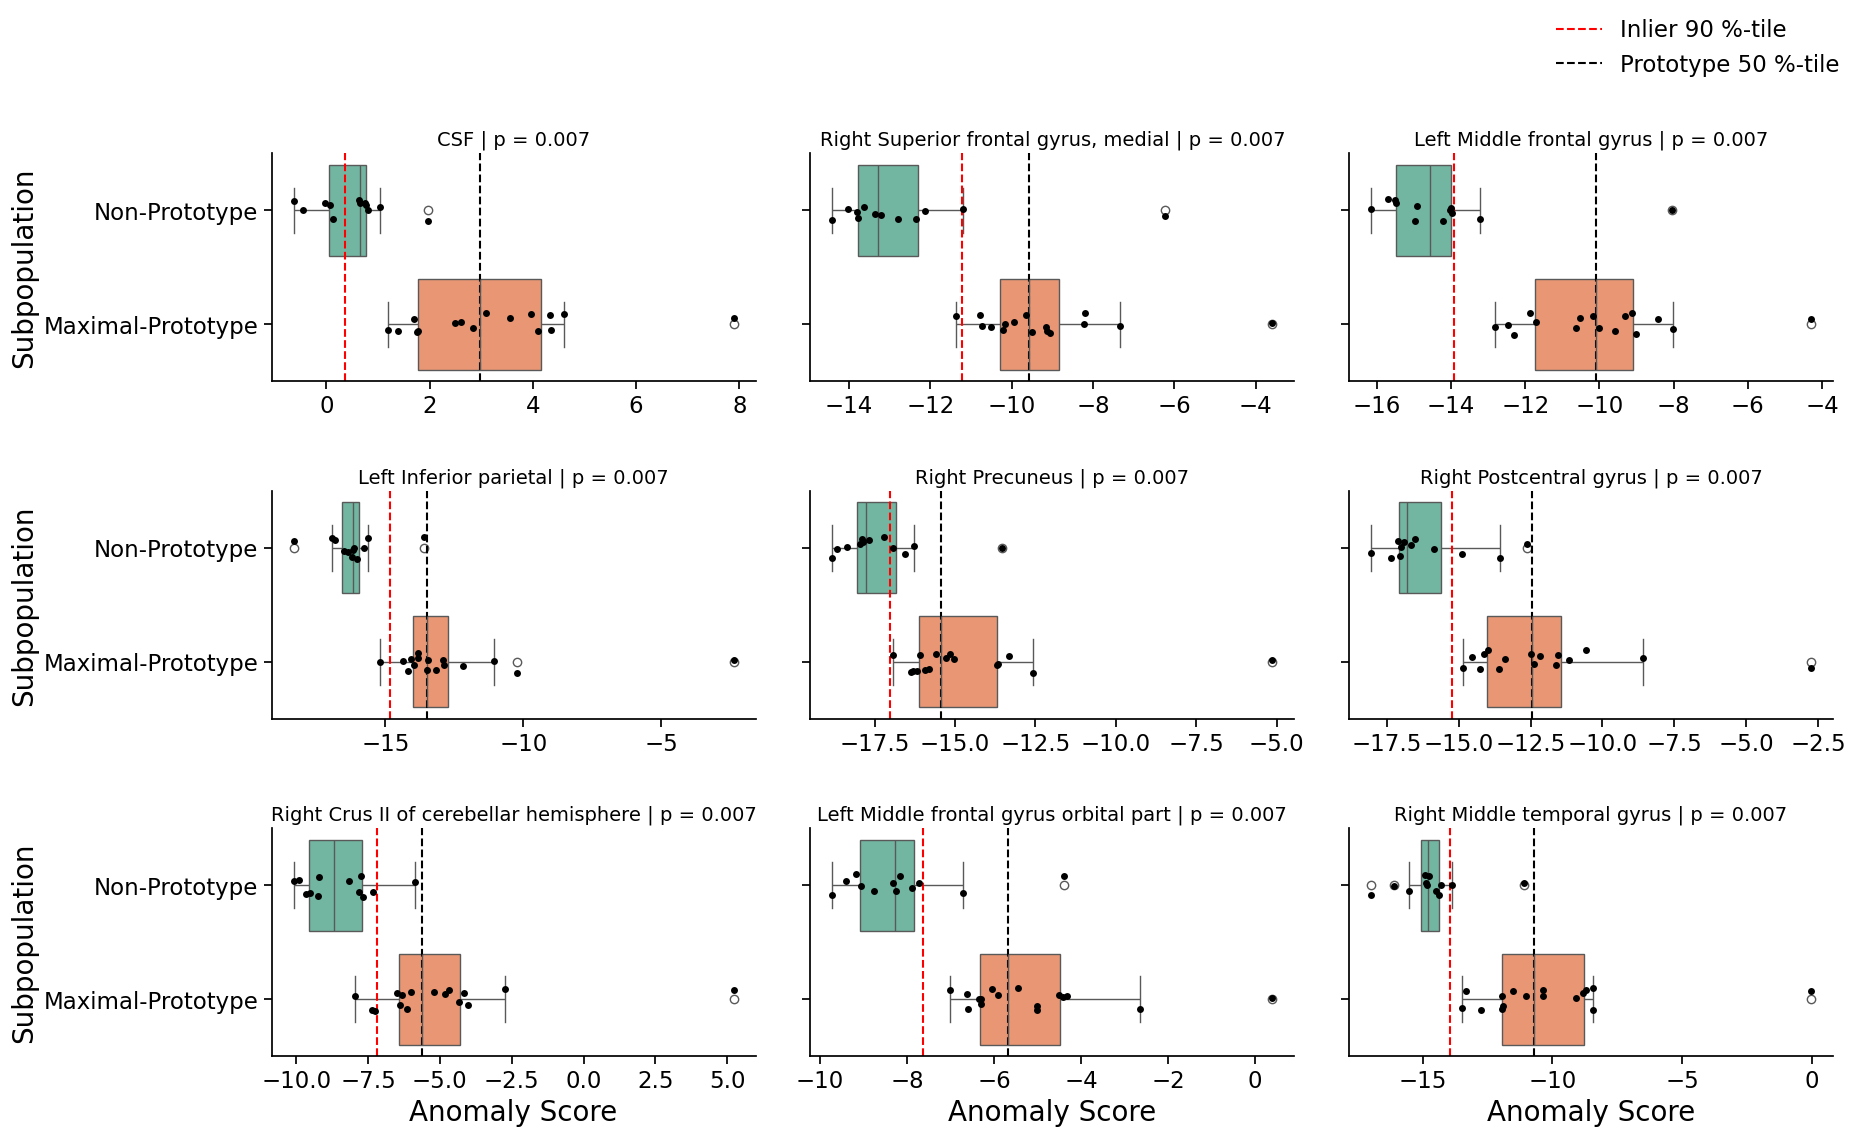

In [56]:
g = sns.FacetGrid(plotdf, col="ROI", col_wrap=3, col_order=roi_order[:9],
                  height=3.5, aspect=1.5, sharex=False, margin_titles=False)
g.map_dataframe(sns.boxplot, x="Anomaly Score", y='Subpopulation', hue='Subpopulation',
                palette='Set2', orient='h')
g.map_dataframe(sns.stripplot, x="Anomaly Score", y='Subpopulation', orient='h', color='black', size=5)
g.map_dataframe(add_refline)
g.add_legend(loc="upper right", bbox_to_anchor=(1, 1.1),)
# g.set_axis_labels(x_var= "Anomaly Score ->", y_var = "Subpopulation", clear_inner=True)
plt.tight_layout(h_pad=2)

# plt.savefig('figures/roi_boxplot.pdf', dpi=150,  bbox_inches='tight')

In [57]:
q = 0.999
refqs = roi_score_likelihoods.query("Cohort == 'IBIS-LR-Typical' ")[significant_prototype_rois["ROI"]].quantile(q)
protomedians = plotdf.query(f"Subpopulation == 'Maximal-Prototype'").groupby('ROI')['Anomaly Score'].median().loc[significant_prototype_rois["ROI"]]
higher_than_99 = [roi for roi in roi_order if protomedians.loc[roi].item() > refqs[roi].item()]
higher_than_99

['CSF',
 'Left Middle frontal gyrus',
 'Right Postcentral gyrus',
 'Left Middle frontal gyrus orbital part',
 'Right Middle temporal gyrus',
 'Right Superior frontal gyrus, dorsolateral',
 'Right Middle frontal gyrus',
 'Left Superior frontal gyrus, orbital part',
 'Left Superior occipital gyrus',
 'Left Superior parietal gyrus',
 'Right Inferior temporal gyrus',
 'Right Inferior frontal gyrus, triangular part',
 'Right Middle frontal gyrus orbital part',
 'Right Superior frontal gyrus, orbital part',
 'Right Superior parietal gyrus',
 'Right Temporal pole: middle temporal gyrus',
 'Right Lobule X of cerebellar hemisphere']

/home/amahmood/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/amahmood/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


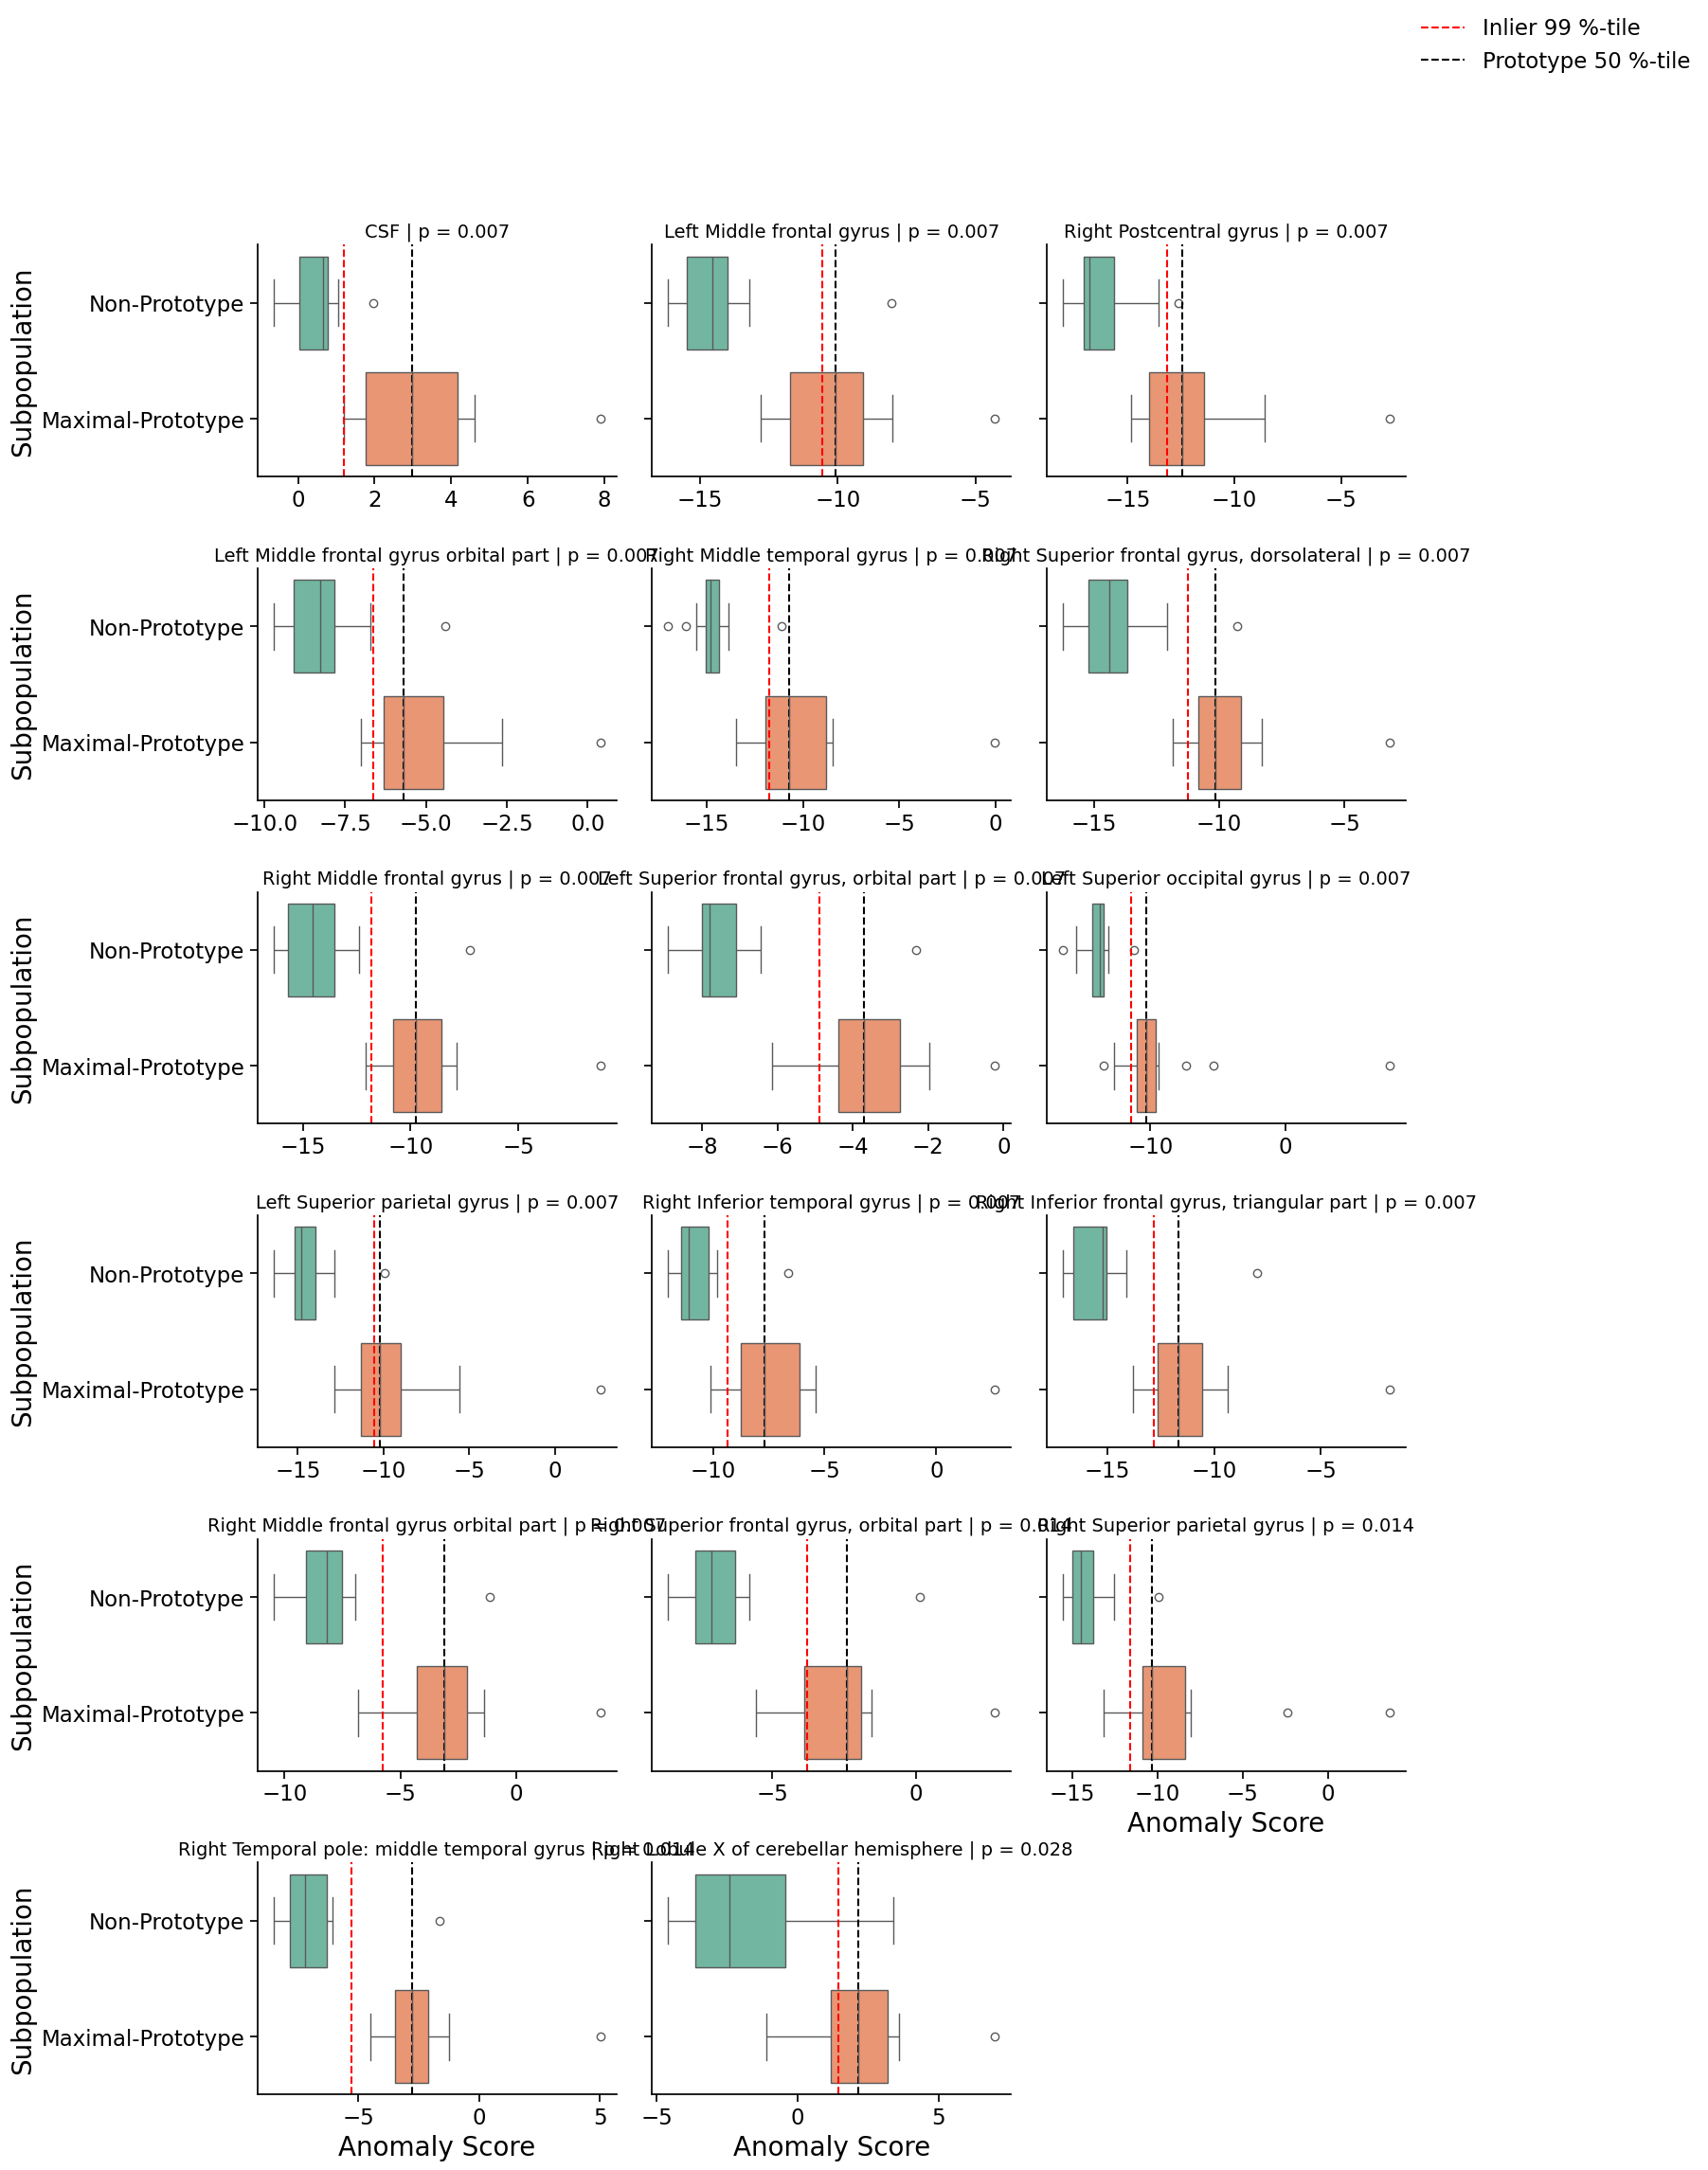

In [58]:
g = sns.FacetGrid(plotdf, col="ROI", col_wrap=3, col_order=higher_than_99,
                  height=3.5, aspect=1.5, sharex=False, margin_titles=False)
g.map_dataframe(sns.boxplot, x="Anomaly Score", y='Subpopulation', hue='Subpopulation',
                palette='Set2', orient='h')
g.map_dataframe(add_refline, q=0.99)
g.add_legend(loc="upper right", bbox_to_anchor=(1, 1.1),)
# g.set_axis_labels(x_var= "Anomaly Score ->", y_var = "Subpopulation", clear_inner=True)
# plt.tight_layout(h_pad=2)

### Sample 11 has missing values and 15 is an outlier in `depressed_percentile`

In [59]:
ds_prototypes[behavior_cols]

CBCL-aggr_behav_score  CBCL-anx_prob_score  CBCL-anxious_score  \
0                    11.0                  4.0                 3.0   
1                     2.0                  1.0                 0.0   
2                    11.0                  4.0                 2.0   
3                     6.0                  0.0                 0.0   
4                     5.0                  1.0                 1.0   
5                     6.0                  2.0                 2.0   
6                     6.0                  3.0                 1.0   
7                     8.0                  0.0                 0.0   
8                     1.0                  1.0                 1.0   
9                    17.0                  6.0                 4.0   
10                    8.0                  3.0                 3.0   
11                   -1.0                 -1.0                -1.0   
12                    1.0                  0.0                 0.0   
13                    6.0                  0.0                 0.0   
14                    4.0                  1.0                 0.0   
15                    3.0                  1.0                 0.0   

    CBCL-attention_hyper_prob_score  CBCL-attention_prob_score  \
0                               5.0                        6.0   
1                               3.0                        4.0   
2                               6.0                        8.0   
3                               5.0                       10.0   
4                               5.0                        6.0   
5                              12.0                       13.0   
6                               6.0                        7.0   
7                               6.0                        7.0   
8                               1.0                        4.0   
9                               8.0                       12.0   
10                              6.0                       11.0   
11                             -1.0                       -1.0   
12                              2.0                        2.0   
13                              2.0                        3.0   
14                              6.0                        8.0   
15                              2.0                        4.0   

    CBCL-conduct_prob_score  CBCL-depressed_score  CBCL-depressive_prob_score  \
0                       2.0                   2.0                         3.0   
1                       0.0                   0.0                         1.0   
2                       3.0                   0.0                         3.0   
3                       2.0                   0.0                         1.0   
4                       1.0                   0.0                         0.0   
5                       1.0                   0.0                         3.0   
6                       4.0                   0.0                         0.0   
7                       5.0                   1.0                         1.0   
8                       1.0                   3.0                         1.0   
9                       8.0                   2.0                         2.0   
10                      2.0                   2.0                         1.0   
11                     -1.0                  -1.0                        -1.0   
12                      0.0                   0.0                         0.0   
13                      2.0                   1.0                         1.0   
14                      2.0                   2.0                         0.0   
15                      2.0                   5.0                         4.0   

    CBCL-externalizing_score  CBCL-internalizing_score  ...  \
0                       13.0                       5.0  ...   
1                        2.0                       1.0  ...   
2                       14.0                       4.0  ...   
3                        7.0                       2.0  ... 

In [60]:
# missing = ds_prototypes.loc[11].ID
# clean_ds_prototypes = ds_prototypes[~ds_prototypes['ID'].isin([missing])]
# len(clean_ds_prototypes)

In [61]:
# clean_ds_prototypes = ds_prototypes[ds_prototypes.ID != ds_prototypes.loc[9].ID]
# len(clean_ds_prototypes)

### Prototype Correlation analysis is done wrt Prototype-significant brain ROIs and all Behavior scores 

In [62]:
# np.random.seed(42)
# non_numeric_cols = ['Cohort', 'ID', 'Identifiers', 'Sex']
# correlation_columns = list(roi_order) + behavior_cols
# corrmatrix, sigcorrdf, rel_rois = run_correlation_analysis(ds_prototypes,
#                                                            behavior_cols=behavior_cols,
#                                                            correlation_thresh=0.0,
#                                                            relevant_roi_columns=list(significant_prototype_rois['ROI']),
#                                                            n_resamples=20_000)

In [63]:
# sigcorrdf.to_csv("data/corr_pvals.csv")
# corrmatrix.to_csv("data/corrmatrix.csv")

In [64]:
corrmatrix = pd.read_csv("data/corrmatrix.csv", index_col=0)
sigcorrdf = pd.read_csv("data/corr_pvals.csv", index_col=0)


sigcorrdf['adjusted-p'] = false_discovery_control(sigcorrdf['p-value'], method='bh')
alpha = 0.01
print(f"Significant: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['p-value'] < alpha).sum()} / {len(sigcorrdf)}")
print(f"FDR: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['adjusted-p'] < alpha).sum()} / {len(sigcorrdf)}")
alpha = 0.1
print(f"FDR: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['adjusted-p'] < alpha).sum()} / {len(sigcorrdf)}")
alpha = 0.3
print(f"FDR: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['adjusted-p'] < alpha).sum()} / {len(sigcorrdf)}")
print()
sigcorrdf.head(3)

Significant: 0.01 -> Significant ROI-Behavior Correlations: 30 / 1400
FDR: 0.01 -> Significant ROI-Behavior Correlations: 0 / 1400
FDR: 0.1 -> Significant ROI-Behavior Correlations: 0 / 1400
FDR: 0.3 -> Significant ROI-Behavior Correlations: 1 / 1400



ROI              Behavior      Corr  p-value  \
1161             Left Angular gyrus  CBCL-depressed_score  0.710932   0.0001   
1301    Left Middle occipital gyrus  CBCL-depressed_score  0.648977   0.0070   
76    Right Inferior temporal gyrus  CBCL-depressed_score  0.644330   0.0009   

      nsamples  adjusted-p  
1161        15    0.139993  
1301        15    0.400536  
76          15    0.307985

### Which Assessment shows high correlation with MSMA scores?

In [65]:
ref_max = reference_likelihoods.quantile(0.99)
mask = sigcorrdf['p-value'] <= (ONE_PERCENT)
sigcorrdf[mask].groupby('Behavior').describe()

Corr                                          \
                               count      mean       std       min       25%   
Behavior                                                                       
CBCL-depressed_score            12.0  0.573599  0.081125  0.432135  0.518485   
CBCL-internalizing_score         5.0  0.525637  0.031760  0.490001  0.498910   
CBCL-sluggish_cogn_tempo_score   1.0  0.610468       NaN  0.610468  0.610468   
CBCL-social_prob_score           2.0  0.596099  0.059607  0.553951  0.575025   
VSA DAS_SA,rd_ABILITY_SCORE      6.0 -0.238448  0.180353 -0.572574 -0.264984   
Vineland-domestic_RAW_SCORE      4.0 -0.467554  0.053884 -0.525076 -0.505164   

                                                             p-value  \
                                     50%       75%       max   count   
Behavior                                                               
CBCL-depressed_score            0.576955  0.632714  0.710932    12.0   
CBCL-internalizing_score        0.524152  0.555334  0.559789     5.0   
CBCL-sluggish_cogn_tempo_score  0.610468  0.610468  0.610468     1.0   
CBCL-social_prob_score          0.596099  0.617173  0.638247     2.0   
VSA DAS_SA,rd_ABILITY_SCORE    -0.203316 -0.112497 -0.083718     6.0   
Vineland-domestic_RAW_SCORE    -0.469029 -0.431418 -0.407081     4.0   

                                          ... nsamples       adjusted-p  \
                                    mean  ...      75%   max      count   
Behavior                                  ...                             
CBCL-depressed_score            0.005191  ...     15.0  15.0       12.0   
CBCL-internalizing_score        0.007100  ...     15.0  15.0        5.0   
CBCL-sluggish_cogn_tempo_score  0.000900  ...     15.0  15.0        1.0   
CBCL-social_prob_score          0.007250  ...     15.0  15.0        2.0   
VSA DAS_SA,rd_ABILITY_SCORE     0.004883  ...     12.0  12.0        6.0   
Vineland-domestic_RAW_SCORE     0.005450  ...     15.0  15.0        4.0   

                                                                            \
                                    mean           std       min       25%   
Behavior                                                                     
CBCL-depressed_score            0.371111  7.749399e-02  0.139993  0.400536   
CBCL-internalizing_score        0.400536  6.206335e-17  0.400536  0.400536   
CBCL-sluggish_cogn_tempo_score  0.307985           NaN  0.307985  0.307985   
CBCL-social_prob_score          0.400536  0.000000e+00  0.400536  0.400536   
VSA DAS_SA,rd_ABILITY_SCORE     0.372796  4.337710e-02  0.307985  0.345122   
Vineland-domestic_RAW_SCORE     0.377398  4.627546e-02  0.307985  0.377398   

                                                              
                                     50%       75%       max  
Behavior                                                      
CBCL-depressed_score            0.400536  0.400536  0.400536  
CBCL-internalizing_score        0.400536  0.400536  0.400536  
CBCL-sluggish_cogn_tempo_score  0.307985  0.307985  0.307985  
CBCL-social_prob_score          0.400536  0.400536  0.400536  
VSA DAS_SA,rd_ABILITY_SCORE     0.400536  0.400536  0.400536  
Vineland-domestic_RAW_SCORE     0.400536  0.400536  0.400536  

[6 rows x 32 columns]

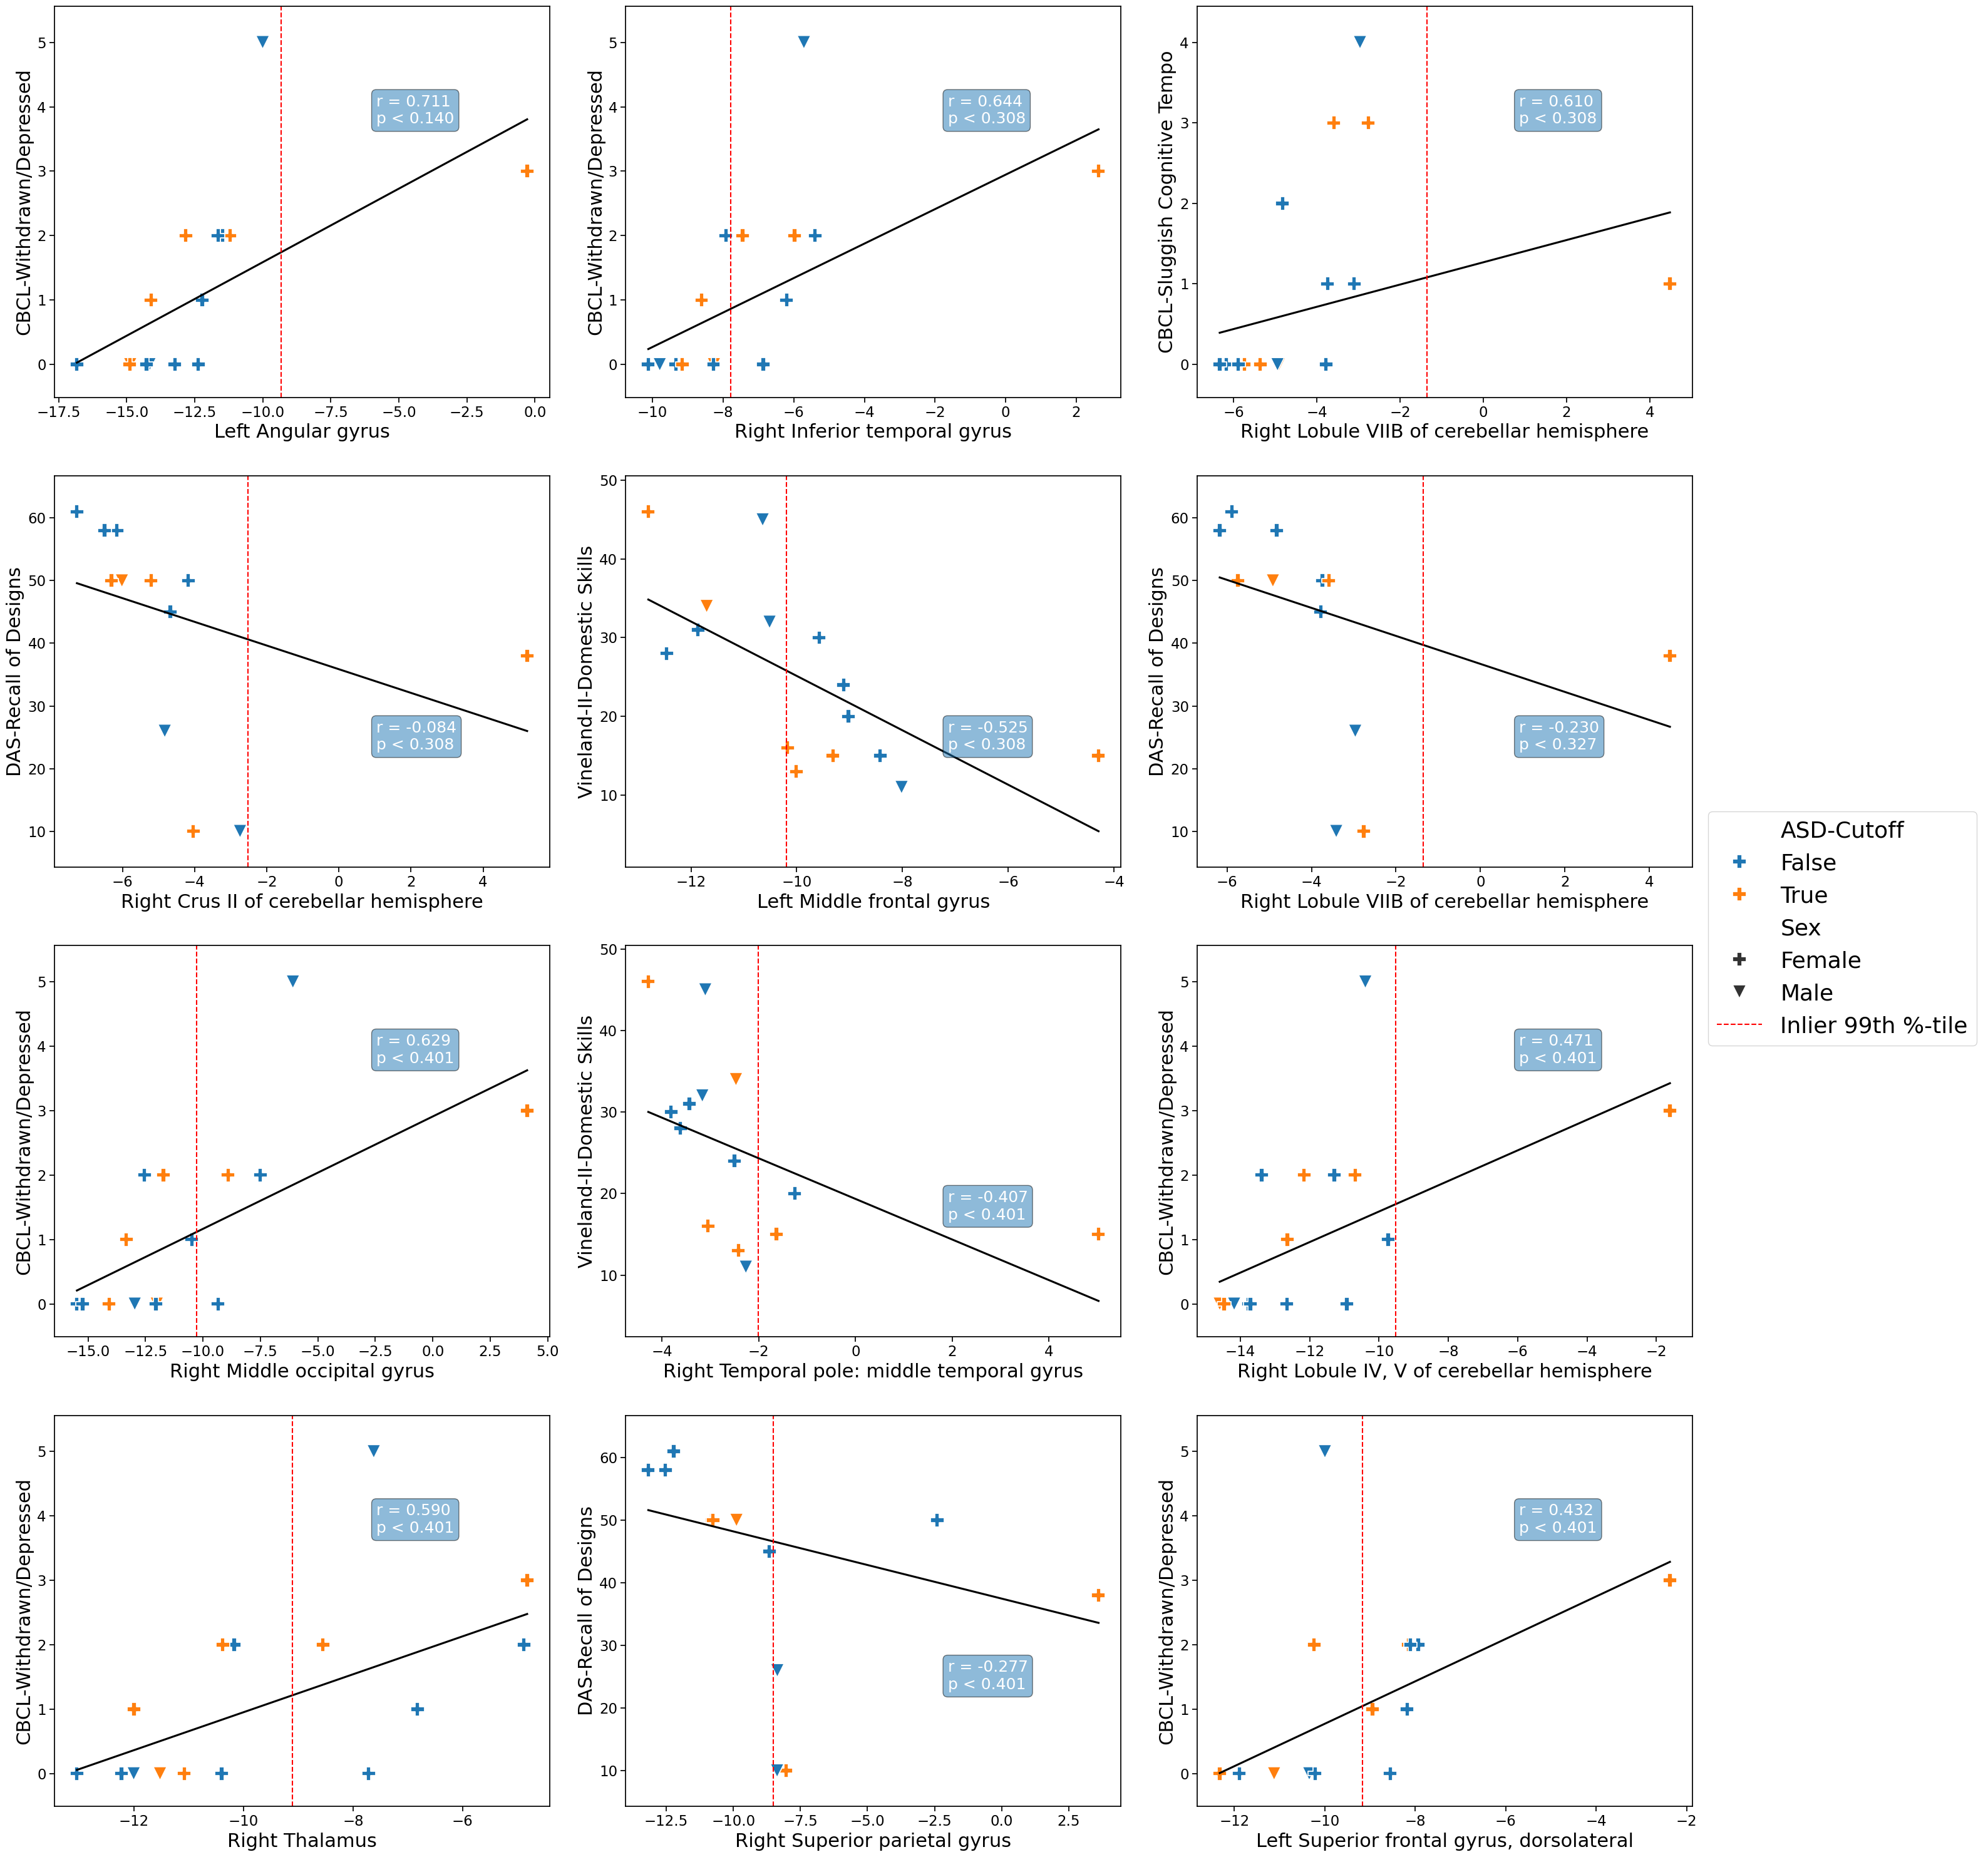

In [66]:
sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 22, "axes.titlesize":22, 'axes.labelweight':'bold'})
fig, axs = plt.subplots(4,3, figsize=(32, 30),)
show_legend = True
for ax, row in zip(axs.flat, sigcorrdf[mask].sort_values(by='p-value').iterrows()):
    ax.set_ymargin(0.01)
    idx, (roi, bhv, corr, p, n, ap) = row
    non_missing_samples = ds_prototypes[bhv] > -1
    points_df = ds_prototypes[non_missing_samples]
#     sns.scatterplot(ds_proto_metadata[non_missing_samples], x=roi, y=bhv, style='Sex', hue='Met ASD CutOff',
#                     palette='tab10',
#                     ax=ax, legend=show_legend, s=200, alpha=1)
    sns.scatterplot(points_df, x=roi, y=bhv, style='Sex', hue='ASD-Cutoff',
                    palette='tab10', markers=['P','v'],
                    ax=ax, legend=show_legend, s=250, alpha=1)
    sns.regplot(points_df, x=roi, y=bhv, scatter=False,
                color='black', ci=None, robust=True, truncate=True, ax=ax)
    
    ymin,ymax = ax.get_ylim()
    offset = 0.1*(ymax-ymin)
    
    ymin = np.clip(ymin-offset, -offset, None)
    ymax += offset
#     if ymin < 0:
#         ax.set_ylim(-0.1, None)
    ax.set_ylim(ymin, ymax)
    ax.axvline(ref_max[roi], c='red',  linestyle='dashed', label='Inlier 99th %-tile')
    ax.set(ylabel= behavior_column_map.get(bhv, bhv))
#     ax.set_title(f"Correlation: {corr:.3f} - p<{p:.3f}")
#     ax.xaxis.label.set_fontsize(14)
#     ax.yaxis.label.set_fontsize(14)
    
    ytext = 0.3 if corr < 0 else 0.7
    text_box = ax.text(0.65, ytext, f"r = {corr:.3f}\np < {ap:.3f}", 
                       transform=ax.transAxes,
                       fontsize=18, color='white', 
                       bbox={'facecolor':'tab:blue', 'alpha':0.5,
                             'boxstyle':"round,pad=0.3"}
                      )

    if show_legend:
        show_legend = False
        fig.legend(loc='center right', fontsize='x-large', ncols=1)
        
    l = ax.legend()
    l.set_visible(False)

# plt.suptitle("Significant Correlations", fontsize=32)
plt.tight_layout(w_pad=2, h_pad=2)
plt.subplots_adjust(right=0.85)
# plt.savefig('figures/regplot.pdf', dpi=150)
# plt.close()

In [67]:
def plot_roi_regression(rows, axs, fig):
    show_legend = True
    for (ax1,ax2), row in zip(axs, rows):

        idx, (roi, bhv, corr, p, n, ap) = row
        non_missing_samples = ds_prototypes[bhv] > -1
        sns.scatterplot(ds_prototypes[non_missing_samples], x=roi, y=bhv, style='ASD-Cutoff', hue='ASD-Cutoff',
                        palette='tab10',
                        ax=ax1, legend=show_legend, s=200, alpha=1)
        ax1.axvline(ref_max[roi], c='red',  linestyle='dashed', label='Inlier 99th %-tile')
        sns.regplot(ds_prototypes[non_missing_samples], x=roi, y=bhv, scatter=False,
                    color='black', ci=None, robust=True, truncate=True, ax=ax1)
        
        ymin,ymax = ax1.get_ylim()
        offset = 0.1*(ymax-ymin)
        ymin = np.clip(ymin-offset, -offset, None)
        ymax += offset
        ax1.set_ylim(ymin, ymax)
        
        ylab = ax1.get_ylabel().replace("_score", "")
        ylab = ylab.replace("_ABILITY_SCORE", "")
        ylab = ylab.replace("_RAW_SCORE", "")
        ax1.set_ylabel(ylab)

        rowdf = ds_prototypes[non_missing_samples].copy()
        rowdf[[roi, bhv]] = rowdf[[roi, bhv]].apply(rankdata)

        sns.scatterplot(rowdf, x=roi, y=bhv, style='ASD-Cutoff', hue='ASD-Cutoff', palette='tab10',
                        ax=ax2, legend=False, s=150, alpha=0.8)
        sns.regplot(rowdf, x=roi, y=bhv, scatter=False, color='black', ci=None,  ax=ax2,)
        ytext = 0.3 if corr < 0 else 0.7
        text_box = ax2.text(0.05, ytext, f"r = {corr:.3f}\np < {ap:.3f}", 
                           transform=ax2.transAxes,
                           fontsize=18, color='white', 
                           bbox={'facecolor':'tab:blue', 'alpha':0.5,
                                 'boxstyle':"round,pad=0.3"}
                          )
        ylab = ax2.get_ylabel().replace("ABILITY_SCORE", "rank").replace("RAW_SCORE", "rank")
        ylab = ylab.replace("score", "rank")
        
        ax2.set_ylabel(ylab)

        if show_legend:
            show_legend = False
            fig.legend(loc='upper right', fontsize='large', ncols=1,  title='Met ASD Cutoff')

        for ax in [ax1,ax2]:
            l = ax.legend()
            l.set_visible(False)

In [68]:
sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 20, "figure.titlesize":36, 'axes.labelweight':'bold'})
rows =  list(sigcorrdf[mask].sort_values(by='adjusted-p').iterrows())

nrows = 3
fig, axs = plt.subplots(nrows,2, figsize=(12, 4.5*nrows),)
figrows =  rows[:nrows]

plot_roi_regression(figrows, axs, fig)

# Add a label below the subplots
fig.suptitle(r"Higher is Anomalous ($\longrightarrow$)", y=0.03, fontsize=32)
plt.tight_layout(w_pad=2, h_pad=2)
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.savefig('figures/rankcorrplot-fig1.pdf', dpi=150);
plt.close()

# fig, axs = plt.subplots(len(rows)-nrows, 2, figsize=(12, 3.8 *(len(rows)-nrows)),)
# # show_legend = True
# figrows =  rows[nrows:]

# plot_roi_regression(figrows, axs, fig)

# # Add a label below the subplots
# fig.suptitle(r"Higher is Anomalous ($\longrightarrow$)", y=0.03, fontsize=32)
# plt.tight_layout(w_pad=2, h_pad=2)
# plt.subplots_adjust(top=0.98, bottom=0.04)
# # plt.savefig('figures/rankcorrplot-fig2.pdf', dpi=150);
# # plt.close()
# # print('saved')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [69]:
pmatrix = corrmatrix.copy()
corrected_pmatrix = corrmatrix.copy()

for row in sigcorrdf.iterrows():
    idx, (roi, bhv, corr, p, n, ap) = row
    pmatrix.loc[roi, bhv] = p
    pmatrix.loc[bhv, roi] = p
    
    corrected_pmatrix.loc[roi, bhv] = ap
    corrected_pmatrix.loc[bhv, roi] = ap

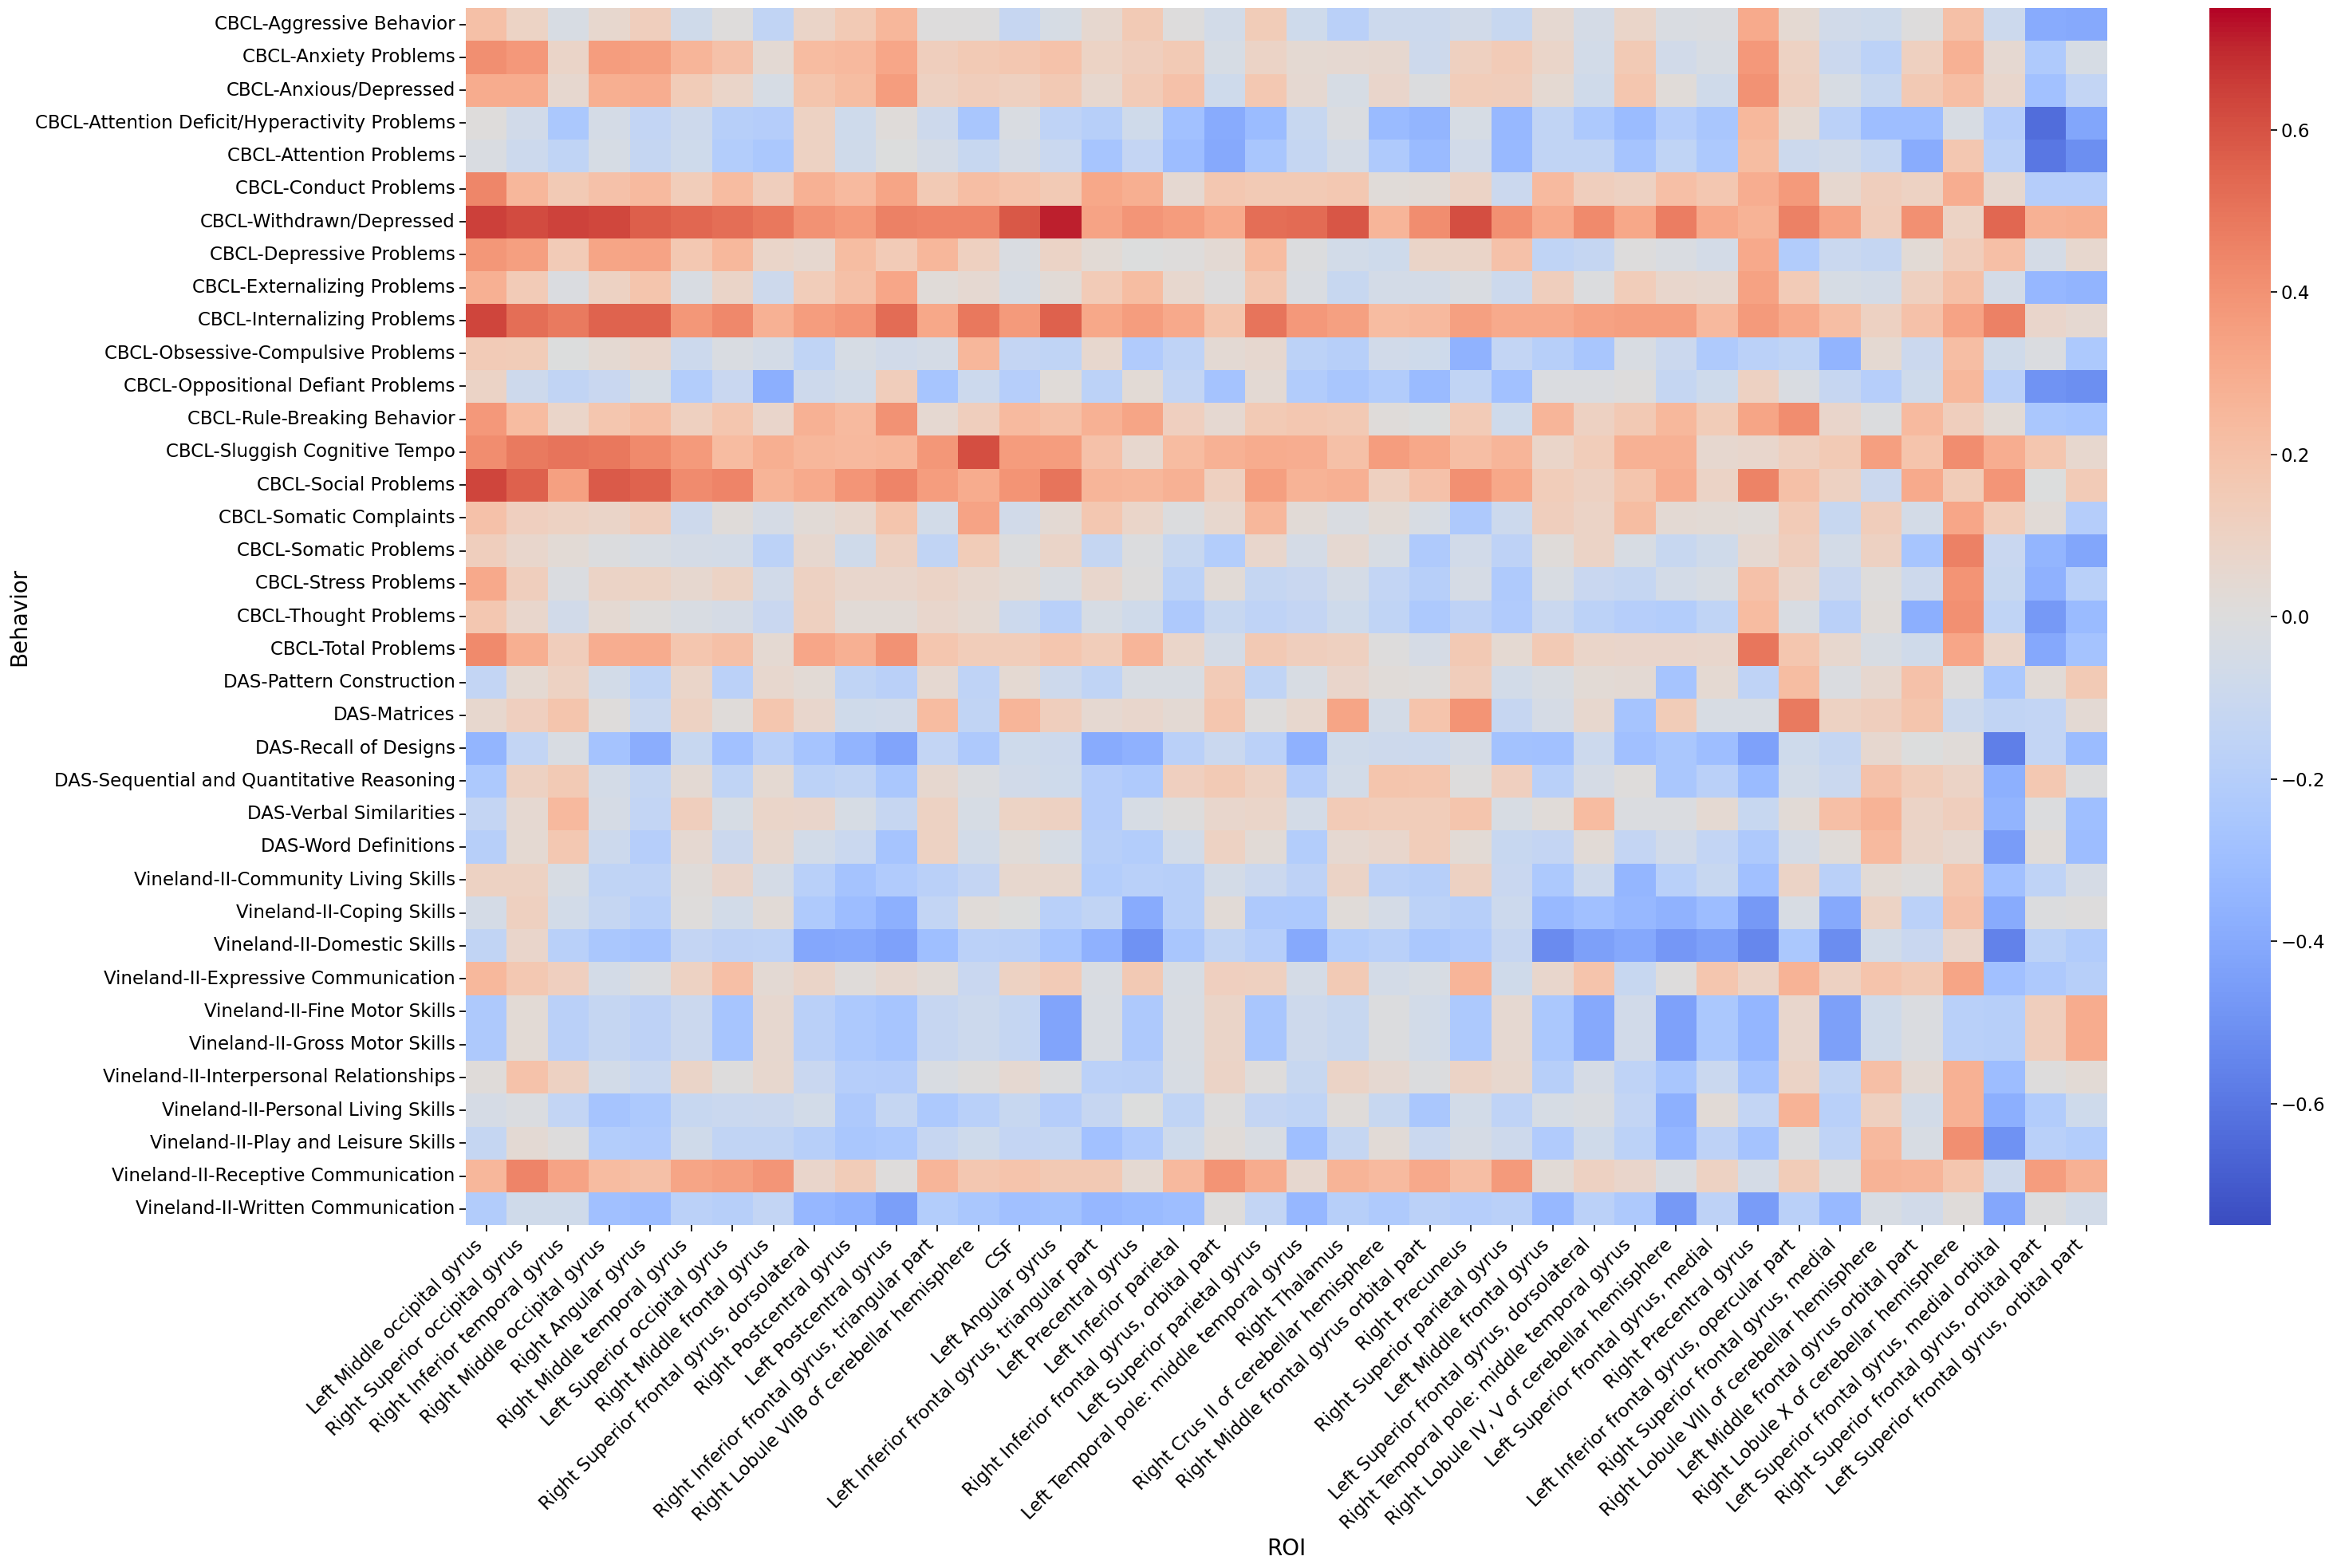

In [70]:
fig, axs = plt.subplots(1,1, figsize=(32,20))
# corrs = corrmatrix.loc[sigcorrdf['ROI'].unique(), sigcorrdf['Behavior'].unique()]
relevant_behaviors = corrmatrix.loc[behavior_cols].mean(1).dropna().index
relevant_rois = corrmatrix.loc[list(significant_prototype_rois['ROI'])].mean(1).sort_values(ascending=False).index
m = corrmatrix.loc[relevant_behaviors, relevant_rois].rename(index=behavior_column_map)

sns.heatmap(m, cmap='coolwarm', vmin=-0.75, vmax=0.75, ax=axs, annot=False)
# axs.set_title(f"Correlation Matrix")
plt.xticks(rotation=45, ha='right');
plt.ylabel("Behavior")
plt.xlabel("ROI")
plt.tight_layout()
plt.savefig('figures/full_corrmatrix.pdf', dpi=150)

### p-value Matrix

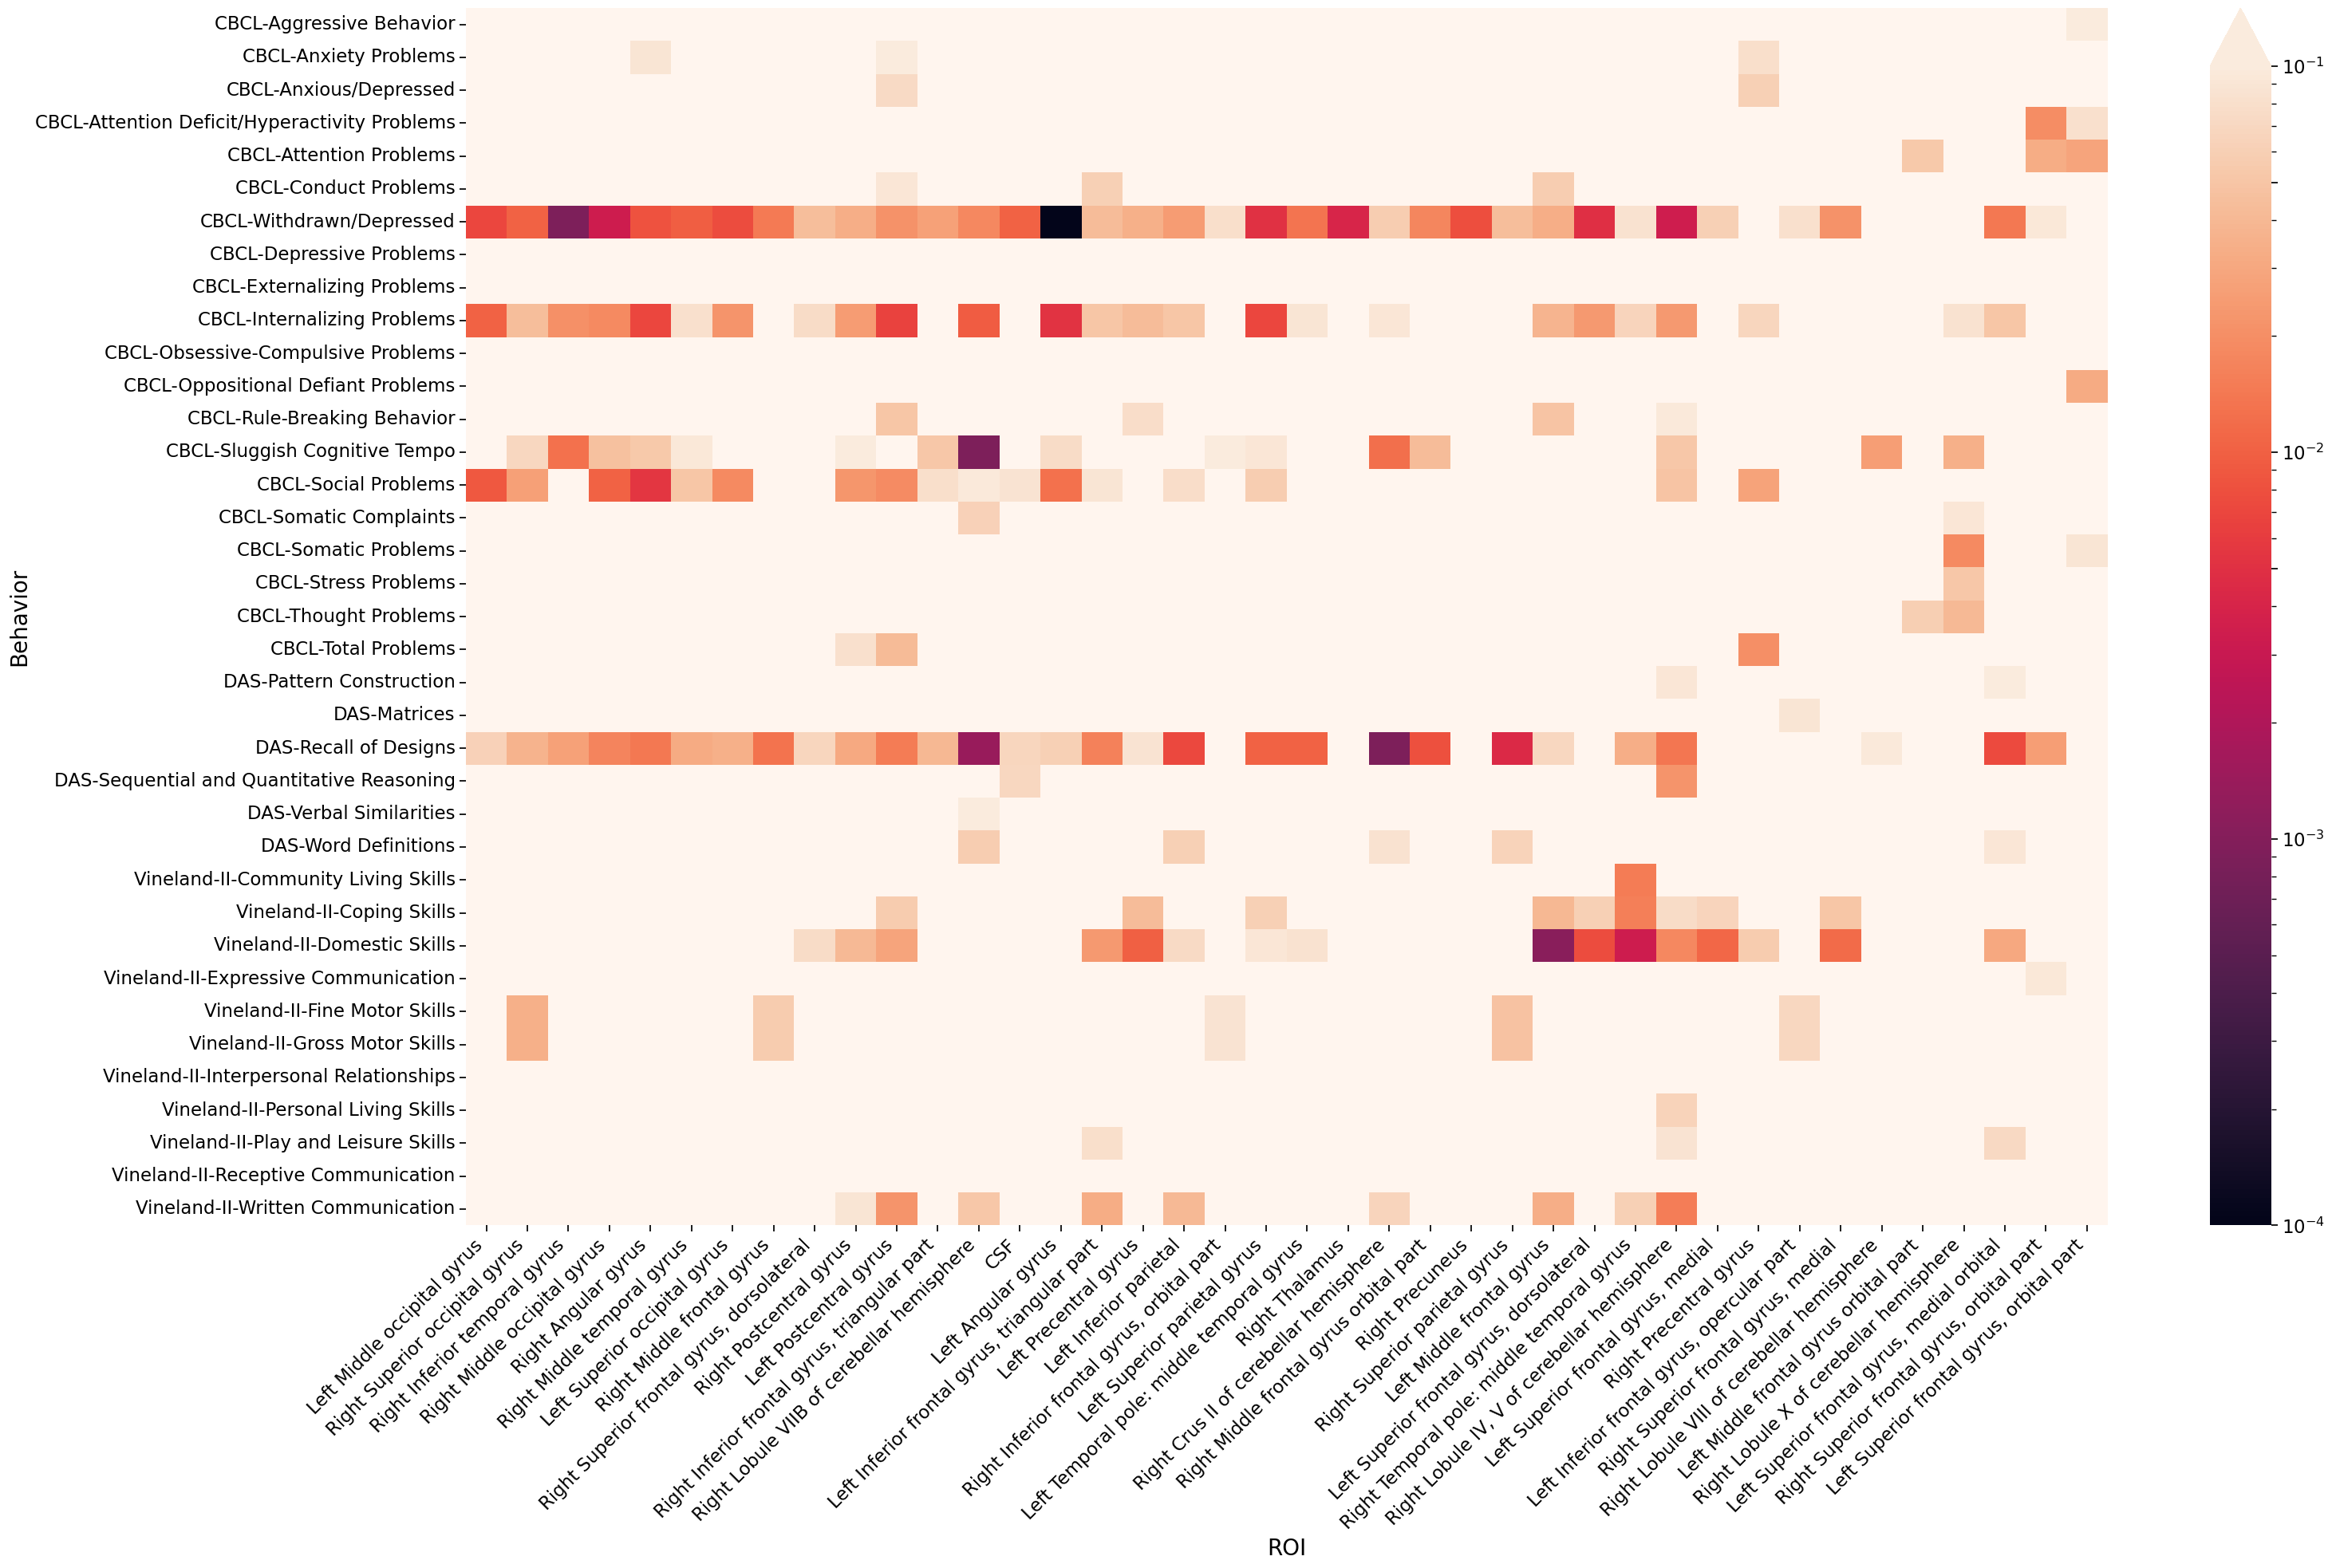

In [71]:
fig, axs = plt.subplots(1,1, figsize=(32,20))
pmax = thresh = 0.1
pmin = 0.0001
log_norm = LogNorm(vmin=pmin, vmax=pmax)
m = pmatrix.loc[relevant_behaviors, relevant_rois].rename(index=behavior_column_map)
significant_ps = m < thresh

sns.heatmap(m*significant_ps, ax=axs, annot=False,
            fmt=".3f",
            norm=log_norm,
            mask=~significant_ps,
#             vmin=0.001, vmax=0.1,
            cmap='rocket', 
            cbar_kws={'ticks': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1], 'extend':'max'}
           )
# sns.heatmap(pmatrix[significant_ps].loc[relevant_behaviors, relevant_rois], ax=axs, annot=False)
axs.set_facecolor("seashell")
# axs.set_title(f"Raw p-values below {thresh}")
plt.xticks(rotation=45, ha='right');
plt.ylabel("Behavior")
plt.xlabel("ROI")
plt.tight_layout()
# plt.savefig('figures/pmatrix.pdf', dpi=150)
# plt.close()

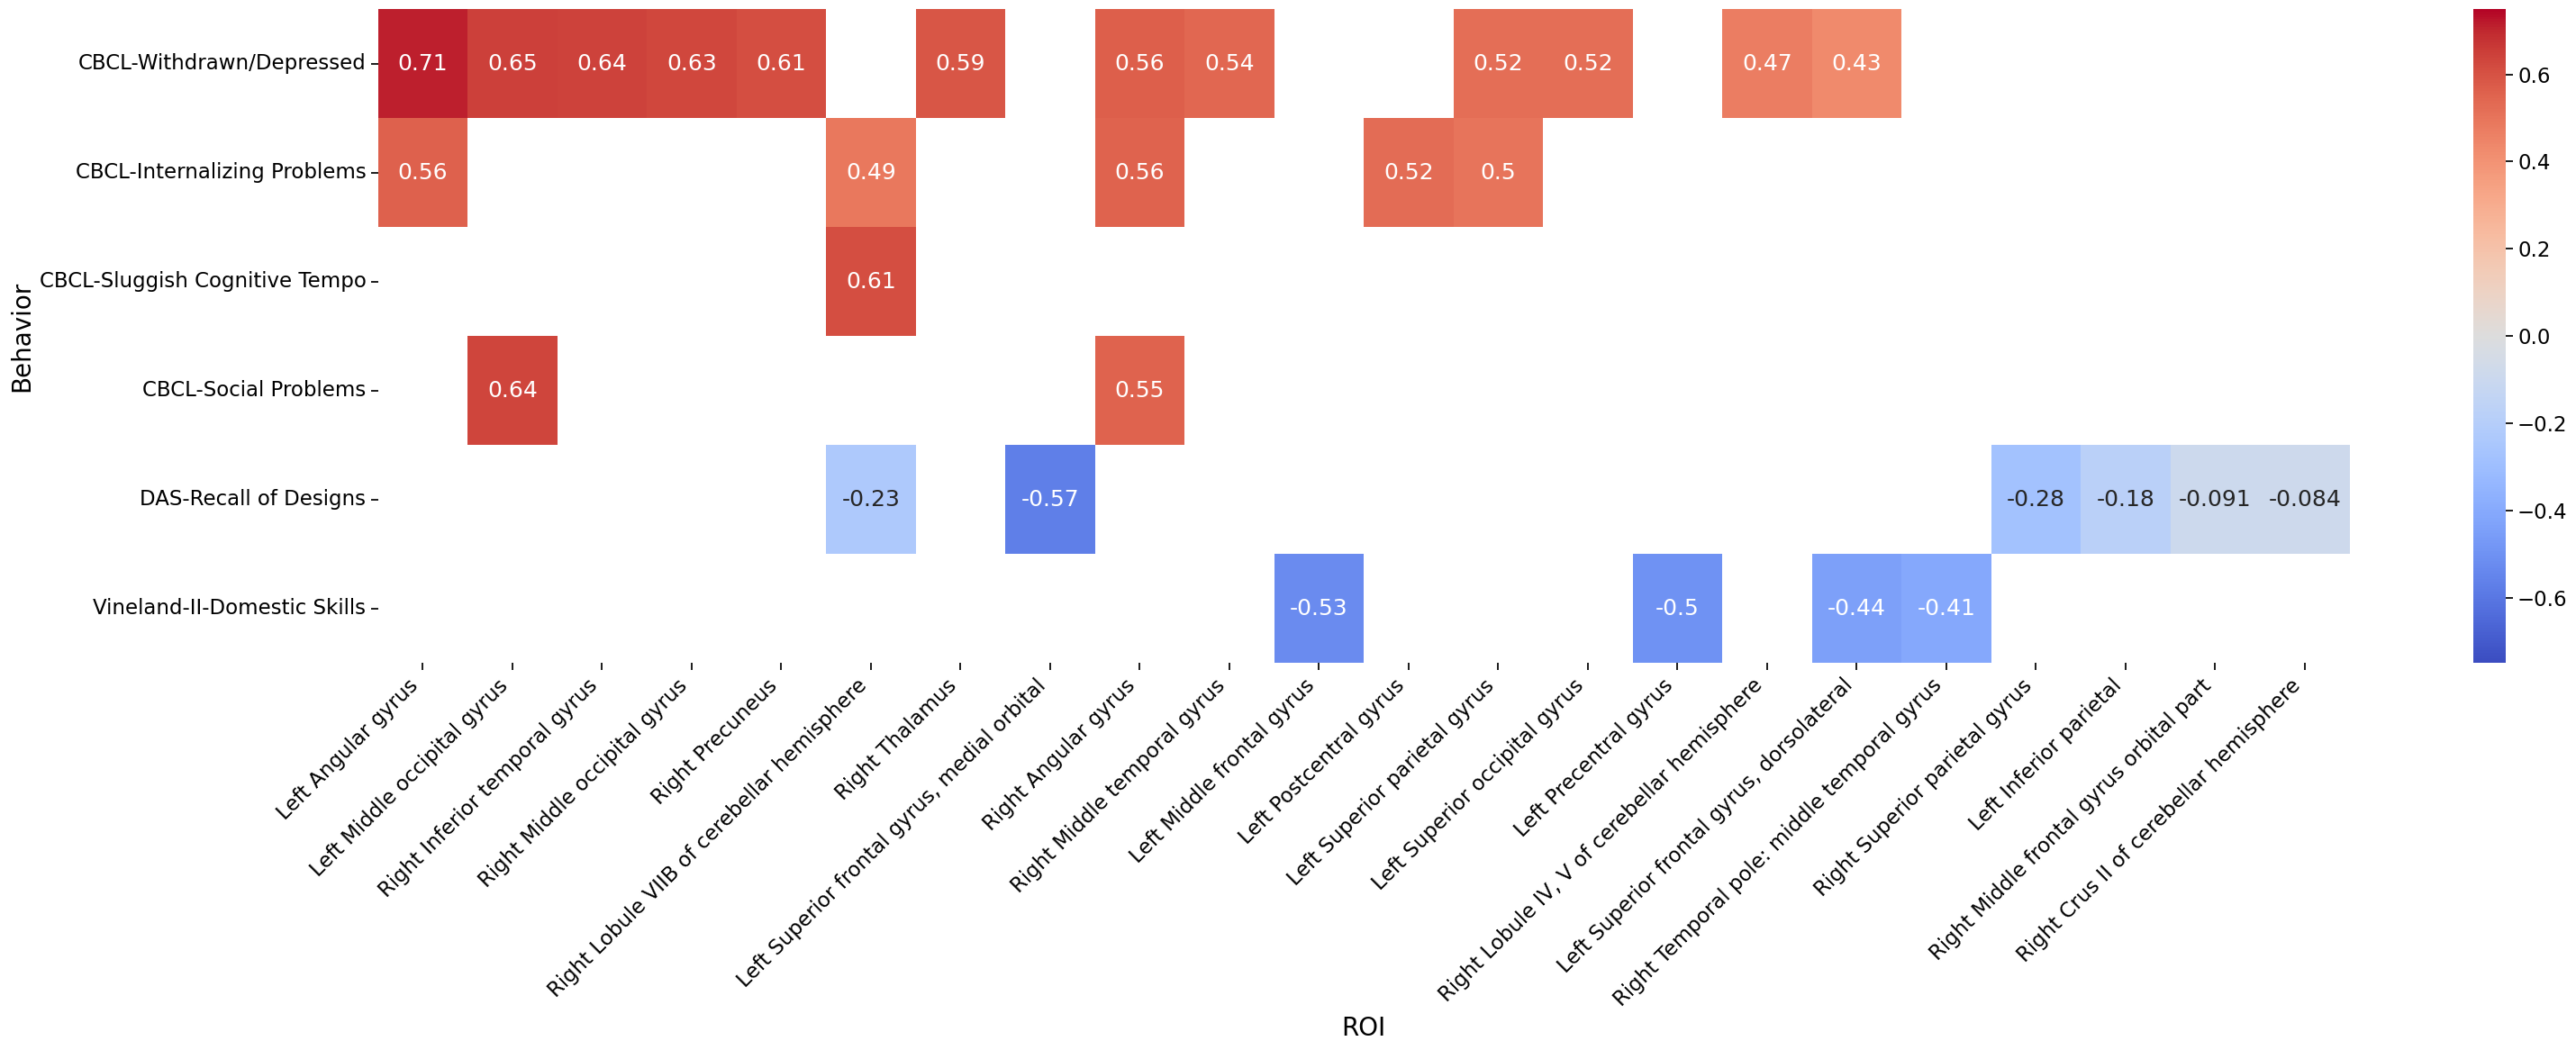

In [72]:
fig, axs = plt.subplots(1,1, figsize=(32,12))
thresh = 0.01

significant_correlation = pmatrix < thresh
relcorrs = sigcorrdf[sigcorrdf['p-value'] < thresh]

relevant_behaviors, relevant_rois = relcorrs['Behavior'].unique(), relcorrs['ROI'].unique()
relevant_behaviors.sort()
# corrs = corrmatrix[significant_correlation].loc[sigcorrdf['ROI'].unique(), sigcorrdf['Behavior'].unique()]
# relevant_behaviors = corrs.count(axis=0)[corrs.count(axis=0) > 1].sort_values(ascending=False).index
# relevant_behaviors = corrs.mean(axis=0)[corrs.count(axis=0) > 0].sort_values(ascending=False).index.unique()
# relevant_rois = corrs.count(axis=1)[corrs.count(axis=1) > 1].sort_values(ascending=False).index

m = corrmatrix[significant_correlation].loc[relevant_behaviors, relevant_rois].rename(index=behavior_column_map)

sns.heatmap(m, cmap='coolwarm', vmin=-0.75, vmax=0.75, ax=axs, annot=True)
# axs.set_title(f"Raw p-values below {thresh}")
plt.xticks(rotation=45, ha='right');
plt.ylabel("Behavior")
plt.xlabel("ROI")
plt.tight_layout()
# plt.savefig('figures/sig_roi_corrs.pdf', dpi=150)

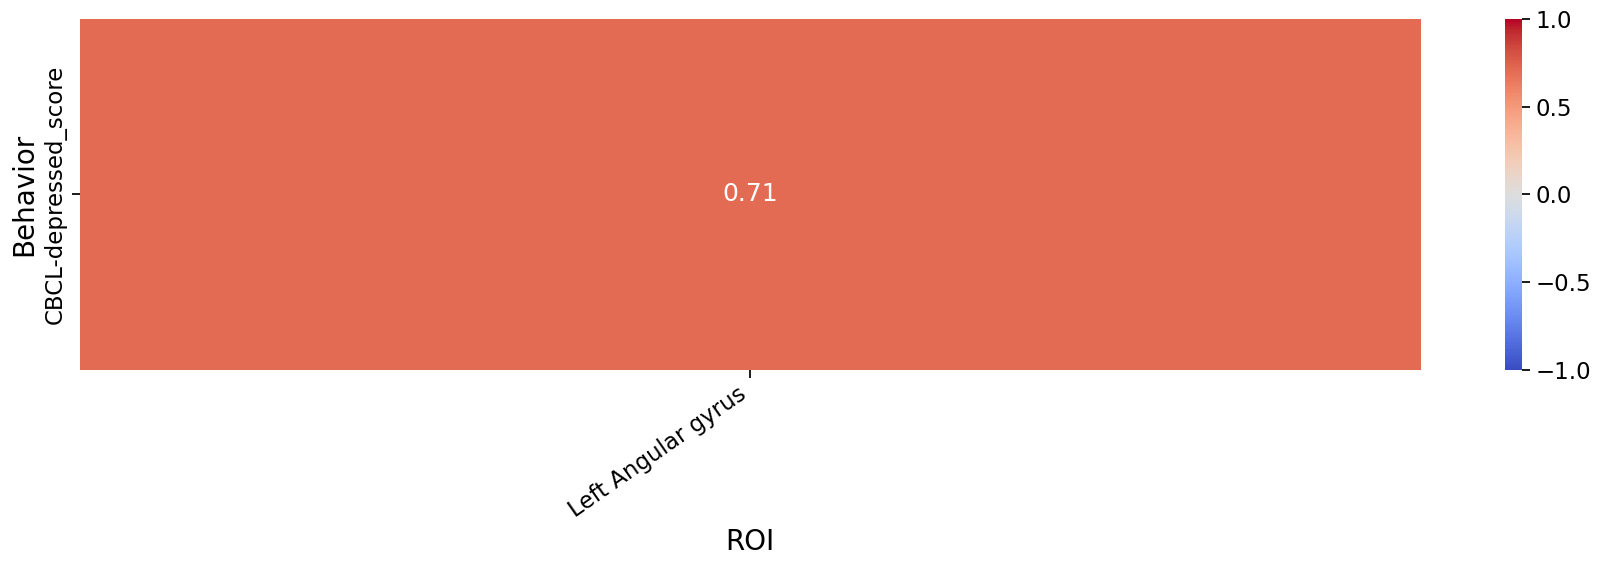

In [73]:
fig, axs = plt.subplots(1,1, figsize=(18,6))
# sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0])
# axs[0].set_xticks([])
thresh = TEN_PERCENT * 3
relcorrs = sigcorrdf[sigcorrdf['adjusted-p'] < thresh]
# corrs = corrmatrix[corrected_pmatrix < TEN_PERCENT].loc[relcorrs['ROI'].unique(), relcorrs['Behavior'].unique()]
# relevant_behaviors = corrs.count(axis=0)[corrs.count(axis=0) > 0].sort_values(ascending=False).index
# relevant_rois = corrs.count(axis=1)[corrs.count(axis=1) > 0].sort_values(ascending=False).index
relevant_behaviors, relevant_rois = relcorrs['Behavior'].unique(), relcorrs['ROI'].unique()

sns.heatmap(corrmatrix[corrected_pmatrix < thresh].loc[relevant_behaviors, relevant_rois],
            annot=True,
            cmap='coolwarm', vmin=-1, vmax=1, ax=axs,)
# axs.set_title(f"Significant Correlations (corrected-p < {TEN_PERCENT})", pad=20)
plt.xticks(rotation=35, ha='right');
plt.ylabel("Behavior")
plt.xlabel("ROI")
plt.tight_layout()
# plt.savefig('figures/corrected_sig_roi_corrs.pdf', dpi=150)

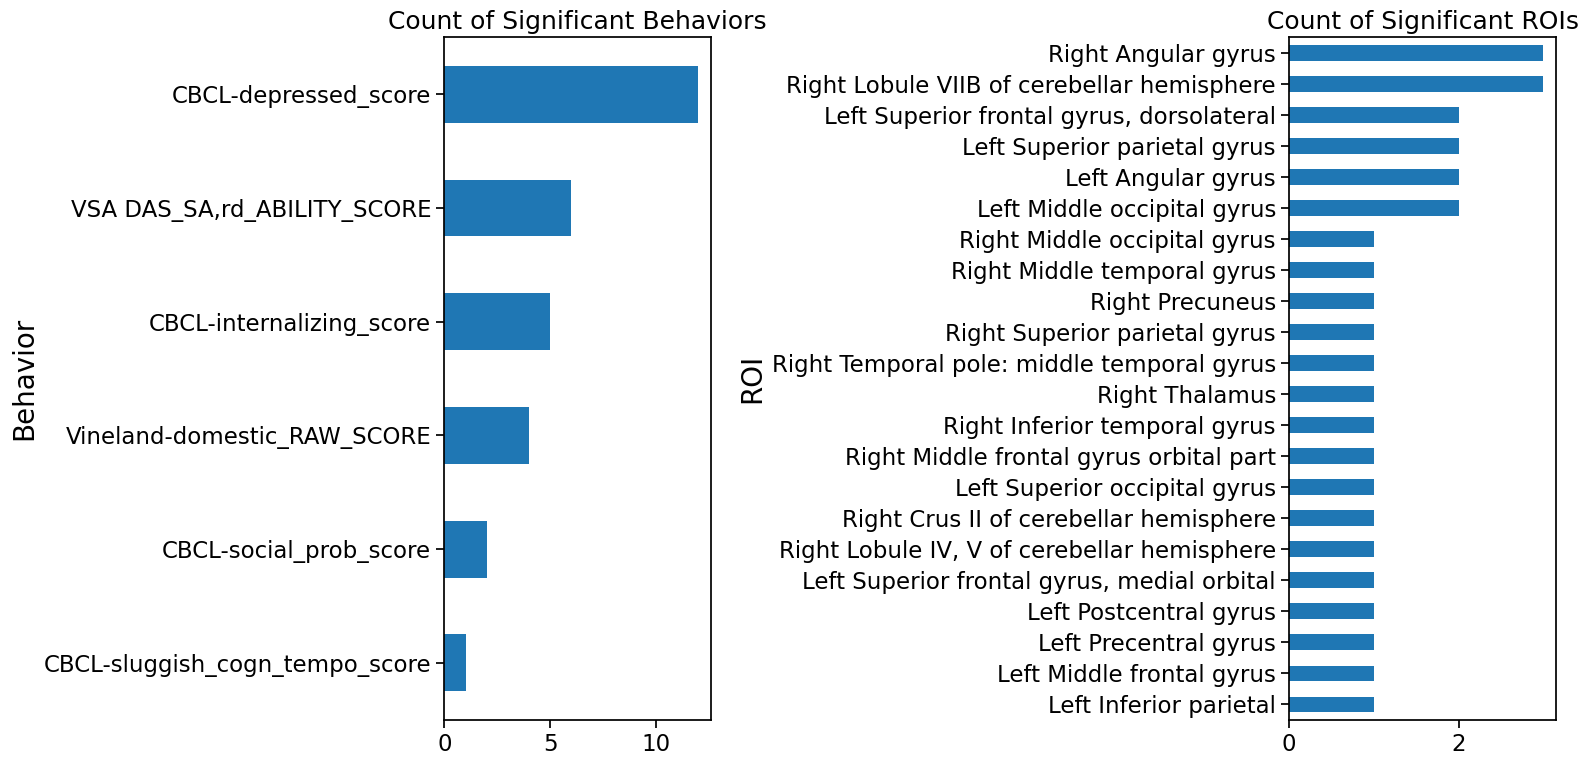

In [74]:
fig, axs = plt.subplots(1,2, figsize=(16,8))

thresh = 0.01
relcorrs = sigcorrdf[sigcorrdf['p-value'] < thresh]
relcorrs.groupby('Behavior')['ROI'].count().sort_values(ascending=True).plot(kind='barh', ax=axs[0])

axs[0].set_title(f"Count of Significant Behaviors")
# plt.xticks(rotation=45, ha='right');

relcorrs.groupby('ROI')['Behavior'].count().sort_values(ascending=True).plot(kind='barh', ax=axs[1])
axs[1].set_title(f"Count of Significant ROIs")
# axs[1].set_xticks(rotation=45, ha='right');
plt.tight_layout()
# plt.title("Number Behavior/ROIs in a Significant Pair")